In [1]:
cd ../TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [2]:
%pylab inline
from TileEM_plot_toolbox import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
DATA_DIR="output"
os.chdir(DATA_DIR)

In [4]:
NParam=50
def plot_majvote_postprocess_PR_curves(objid,legend=False):
    '''
	Plot PR curves for Majority Vote
	'''
    plt.figure()
    plt.title("Object #{}".format(objid))
    # Worker Individual Precision and Recall based on their BB drawn for this object
    worker_precision_lst,worker_recall_lst = compute_worker_PR_obj(objid)
    plt.plot(worker_recall_lst ,worker_precision_lst , '.',color="gray",label="Worker")
    # Plotting PR from Top-k Majority vote 
    print "Top k Majority Vote"
    tiles = pkl.load(open("../{0}/tiles{1}.pkl".format(DATA_DIR,objid),'r'))
    objIndicatorMat = pkl.load(open("../{0}/indMat{1}.pkl".format(DATA_DIR,objid),'r'))
    k_lst = np.arange(1,len(tiles),max(int((len(tiles)-1)/NParam),1))
#     k_lst = [1,5,10,15,20,25,30]
#     k_lst = np.arange(1,int(len(tiles)/5.),50)
    Maj_topk_precision_lst = []
    Maj_topk_recall_lst = []
    for  k in tqdm(k_lst):
        Maj_topk_precision,Maj_topk_recall= compute_PR_obj(objid, majority_topk=k)
        Maj_topk_precision_lst.append(Maj_topk_precision)
        Maj_topk_recall_lst.append(Maj_topk_recall)
    Maj_topk_recall_lst = np.array(Maj_topk_recall_lst)
    Maj_topk_precision_lst = np.array(Maj_topk_precision_lst)
    order = np.argsort(Maj_topk_recall_lst)
    plt.plot(Maj_topk_recall_lst[order],Maj_topk_precision_lst[order], linestyle='-', linewidth=1,marker='D',color="cyan",label="Majority Top-k")
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    plt.ylabel("Precision",fontsize=13)
    plt.xlabel("Recall",fontsize=13)
    if legend: plt.legend(loc="bottom left",numpoints=1)
    plt.savefig("PR_obj{}.pdf".format(objid))

In [5]:
def compute_PR_obj(objid,experiment_idx=0,threshold=-1,topk=-1,majority_topk=-1,PLOT_HEATMAP=False):
    '''
    Compute the precision recall for a object indexed by objid
    based on T-search strategy indexed by experiment_idx, where:
    0 = Avrg 
    1 = Median
    2 = Local Search
    3 = Exhaustive Search
    The post-processing method could either be gamma threshold, top-k gamma, or top-k majority vote.
    OPTIONAL: Plot Gamma Heatmap 
    If PLOT_HEATMAP="all-region", plot all tile heatmap region whether selected from solnset or not
    '''
    INCLUDE_ALL=False
    if PLOT_HEATMAP=="all-region": INCLUDE_ALL=True
    
    try:
        tiles = pkl.load(open("../{0}/tiles{1}.pkl".format(DATA_DIR,objid),'r'))
        gammas = pkl.load(open("gfile{}.pkl".format(objid),'r'))#ga,gm,gl,ge
        objIndicatorMat = pkl.load(open("../{0}/indMat{1}.pkl".format(DATA_DIR,objid),'r'))
        # Deriving new solution set from different thresholding criteria
        if threshold!=-1:
            procstr = "Gamma>{}".format(threshold)
            solnset = getSolutionThreshold(gammas[experiment_idx],threshold=threshold) 
            if PLOT_HEATMAP: mask = plot_tile_heatmap(objid,solnset ,tiles,gammas[experiment_idx],PLOT_BBG=True,PLOT_GSOLN=True,INCLUDE_ALL=INCLUDE_ALL)
        elif topk!=-1:
            procstr="Gamma k={}".format(topk)
            solnset = getSolutionTopK(gammas[experiment_idx],k=topk)
            if PLOT_HEATMAP: mask = plot_tile_heatmap(objid,solnset ,tiles,gammas[experiment_idx],PLOT_BBG=True,PLOT_GSOLN=True,INCLUDE_ALL=INCLUDE_ALL)
            if DEBUG:
	        	print procstr
	        	print solnset
	        	print np.array(gammas[experiment_idx])[solnset]
        elif majority_topk!=-1:
            
            tile_votes = np.sum(objIndicatorMat[:-1],axis=0)
            procstr="Majority k={}".format(majority_topk)
            solnset = getSolutionTopK(tile_votes,k=majority_topk)
            if PLOT_HEATMAP: 
                mask = plot_tile_heatmap(objid,solnset ,tiles,tile_votes,PLOT_BBG=True,PLOT_GSOLN=True,INCLUDE_ALL=INCLUDE_ALL)
        elif area_topk!=-1:
            tile_area = objIndicatorMat[-1]
            procstr="Area k={}".format(majority_topk)
            solnset = getSolutionTopK(tile_area,k=majority_topk)
        precision,recall = compute_approxPR(objid,solnset,tiles,objIndicatorMat)
        if PLOT_HEATMAP:
	        font0 = matplotlib.font_manager.FontProperties()
	        font1=font0.copy()
	        font1.set_size('large')
	        font1.set_weight('heavy')
	        plt.figtext(0.60,0.75,'{0}\n P={1:.2f}, R={2:.2f}'.format(procstr,precision,recall),color='black',fontproperties=font1,ha='center')
    except(IOError):
        print "IOERROR"
        pass 
    return precision,recall


In [6]:
def compute_approxPR(objid,solnset,tiles,objIndicatorMat):
    '''
    Compute precision recall against ground truth bounding box
    for a given solution set and tile coordinates.
    the approxPR algorithm just adds all tile area assuming no overlap rather than joining
    '''
    tile_areas = objIndicatorMat[-1]
    joined_bb_area = np.sum(tile_areas[solnset])
    #jbb = np.sum([tiles[tidx].area for tidx in solnset])
    #print jbb
    ground_truth_match = my_BBG[my_BBG.object_id==objid]
    x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
    BBG = shapely.geometry.Polygon(zip(x_locs,y_locs))
    #Intersecting tiles are tiles in solution set that also lie in BBG
    intersect_area=0
    for tidx in solnset:
        if BBG.contains(tiles[tidx]):
            intersect_area += tiles[tidx].area
#     print joined_bb_area            
#     print intersect_area
    if float(joined_bb_area)!=0:
        precision = intersect_area/float(joined_bb_area)
    else:
        # Empty solution set
        precision = -1
    recall = intersect_area/BBG.area
    #This patches up PR>1 because intersect_area using the slow intersection method can sometimes be larger since overlap area may not be completely deducted, so the estimate is a bit larger than the actual area, but not by much 
    if recall>1:
        recall=1
    if precision>1:
        precision=1
#     print precision,recall
    return precision,recall

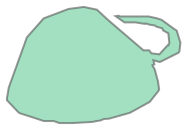

In [85]:
tiles[4360]

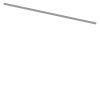

In [86]:
tiles[5121]

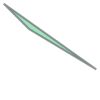

In [87]:
tiles[4264]

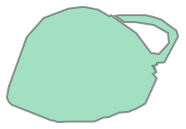

In [88]:
tiles[1160]

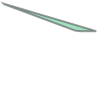

In [90]:
tiles[4004]

[3190]
[3190 4850]
[3190 4850 4360]
[3190 4850 4360 5121]
[3190 4850 4360 5121 4264]
[3190 4850 4360 5121 4264 1160]
[3190 4850 4360 5121 4264 1160 4004]
[3190 4850 4360 5121 4264 1160 4004  863]
[3190 4850 4360 5121 4264 1160 4004  863 3911]


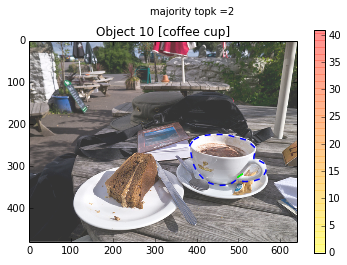

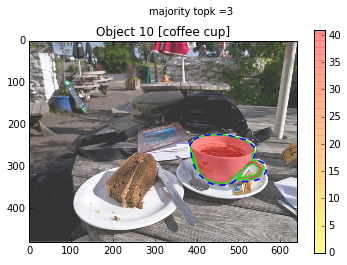

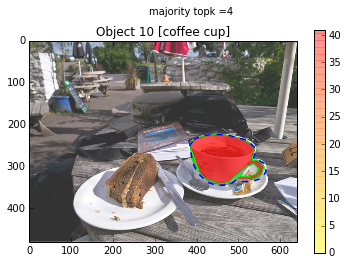

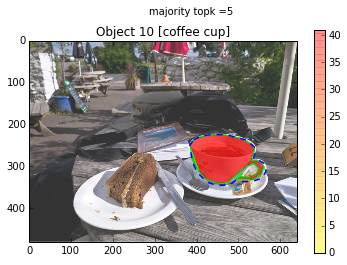

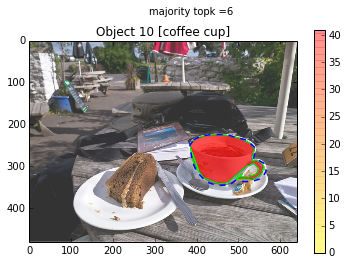

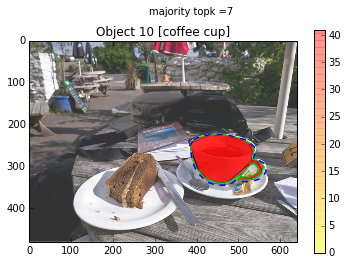

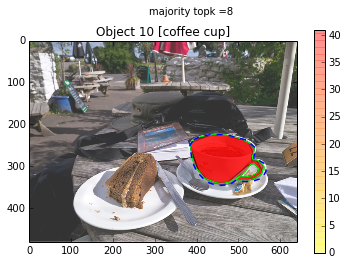

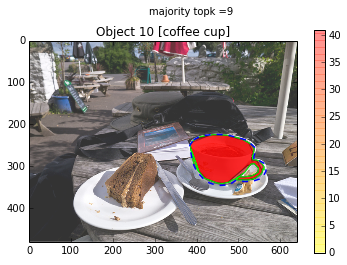

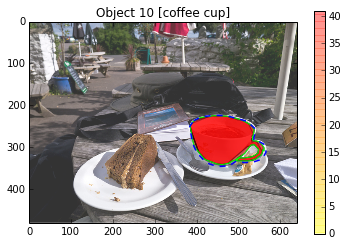

In [80]:
objid=10
tiles = pkl.load(open("../{0}/tiles{1}.pkl".format(DATA_DIR,objid),'r'))
objIndicatorMat = pkl.load(open("../{0}/indMat{1}.pkl".format(DATA_DIR,objid),'r'))
k_lst = np.arange(1,10)
tile_votes = np.sum(objIndicatorMat[:-1],axis=0)
for majority_topk in k_lst:
    solnset = getSolutionTopK(tile_votes,k=majority_topk)
    print solnset
    plt.suptitle("majority topk ={}".format(majority_topk))
    mask = plot_tile_heatmap(objid,solnset ,tiles,tile_votes,PLOT_BBG=True,PLOT_GSOLN=True,INCLUDE_ALL=False)

The tiles are not exactly non-overalpping 

Top k Majority Vote


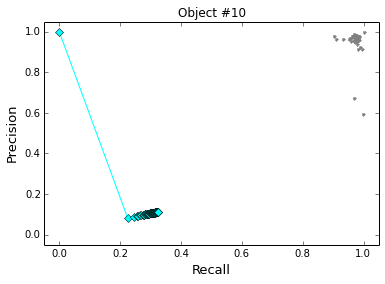

In [74]:
plot_majvote_postprocess_PR_curves(10,legend=False)

Top k Majority Vote


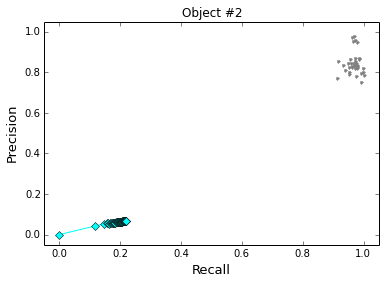

In [68]:
plot_majvote_postprocess_PR_curves(2,legend=False)

Top k Majority Vote


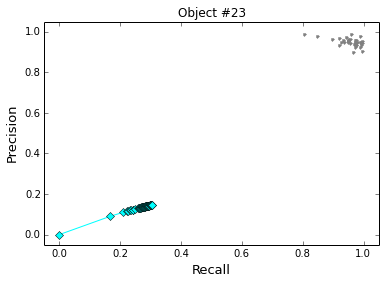

In [69]:
plot_majvote_postprocess_PR_curves(23,legend=False)

In [91]:
tiles

 ...]

In [104]:
duplicate_count = 0
verified_tiles = []
for tidx in tqdm(range(len(tiles))): 
    t=tiles[tidx]
    for vtidx in range(len(verified_tiles)):
        vt = tiles[vtidx]
        try:
            overlap_score=overlap(vt,t)
            if overlap_score>0.2:
                print "Duplicate tiles: ",tidx,vtidx, overlap_score
                duplicate_count+=1
                break
        except(shapely.geos.TopologicalError):
            print "Error",tidx,vtidx
    verified_tiles.append(t)

  1%|          | 26/5143 [00:00<00:21, 241.91it/s]

Duplicate tiles:  25 24 1.0
Duplicate tiles: 

  1%|          | 52/5143 [00:00<00:33, 150.23it/s]

 50 27 1.0
Duplicate tiles: 

  2%|▏         | 78/5143 [00:00<00:47, 106.72it/s]

 69 63 0.999999999999
Duplicate tiles:  70 66 0.999999999999
Duplicate tiles: 

  2%|▏         | 104/5143 [00:01<01:05, 77.03it/s]

 97 94 0.999999999893
Duplicate tiles:  109 23 0.511880619173
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (403.896 227.857, 403.961 227.825) and LINESTRING (403.961 227.825, 403 228) at 403.96116504854365 227.82524271844665


 115 7 0.852620160269
Error

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (403.896 227.857, 403.961 227.825) and LINESTRING (403.961 227.825, 403 228) at 403.96116504854365 227.82524271844665
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (409 226, 413.143 225.64) and LINESTRING (411.76 225.76, 413.411 225.535) at 411.76000000000016 225.75999999999999
  3%|▎         | 130/5143 [00:02<01:20, 62.34it/s]

 126 63
Error 126 69
Error 126 111
Duplicate tiles: 

  3%|▎         | 156/5143 [00:02<01:33, 53.29it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (409 226, 413.143 225.64) and LINESTRING (411.76 225.76, 413.411 225.535) at 411.76000000000016 225.75999999999999


 139 102 1.0
Error

  5%|▌         | 260/5143 [00:07<02:28, 32.92it/s]

 157 126
Duplicate tiles:  158 136 0.999999999991
Duplicate tiles: 

  6%|▌         | 286/5143 [00:09<02:41, 29.99it/s]

 278 245 1.0
Duplicate tiles: 

  6%|▌         | 312/5143 [00:11<02:55, 27.47it/s]

 289 205 0.246558902502
Duplicate tiles: 

  7%|▋         | 364/5143 [00:15<03:20, 23.87it/s]

 331 51 0.250946365487
Duplicate tiles: 

  8%|▊         | 390/5143 [00:17<03:32, 22.34it/s]

 373 296 0.71060690376
Duplicate tiles:  405 401 0.285463271479
Duplicate tiles:  410 404 0.716391788803
Duplicate tiles:  411 400 0.522536570875
Duplicate tiles:  414 318 0.999999970999
Duplicate tiles: 

 10%|▉         | 494/5143 [00:28<04:25, 17.54it/s]

 415 412 0.253885973405
Duplicate tiles:  499 498 0.999999936739
Duplicate tiles: 

 10%|█         | 520/5143 [00:31<04:38, 16.61it/s]

 517 454 0.56511879312
Duplicate tiles: 

 11%|█         | 546/5143 [00:34<04:49, 15.85it/s]

 542 264 0.64353437049
Duplicate tiles: 

 11%|█         | 572/5143 [00:37<05:01, 15.17it/s]

 552 471 0.229322429036
Duplicate tiles:  580 274 0.321592658673
Duplicate tiles: 

 12%|█▏        | 598/5143 [00:41<05:11, 14.57it/s]

 596 261 0.791497644358
Duplicate tiles:  602 206 0.418960969833
Duplicate tiles:  605 471 0.650382582685
Duplicate tiles:  608 545 0.999999999999
Duplicate tiles: 

 12%|█▏        | 624/5143 [00:44<05:22, 14.00it/s]

 617 407 0.999999986113
Duplicate tiles:  627 487 0.793706179848
Duplicate tiles:  629 628 0.999999994165
Duplicate tiles:  633 561 0.687989203779
Duplicate tiles:  638 620 0.230719663465
Duplicate tiles: 

 13%|█▎        | 650/5143 [00:48<05:33, 13.47it/s]

 641 175 0.298974722813
Duplicate tiles:  651 586 0.999999998934
Duplicate tiles:  664 639 0.250675818941
Duplicate tiles: 

 13%|█▎        | 676/5143 [00:52<05:46, 12.90it/s]

 666 446 1.0
Duplicate tiles:  683 281 0.214380411686
Duplicate tiles:  688 427 1.0
Duplicate tiles: 

 14%|█▎        | 702/5143 [00:56<05:56, 12.45it/s]

 695 591 0.438779519392
Duplicate tiles: 

 14%|█▍        | 728/5143 [01:00<06:07, 12.02it/s]

 711 131 0.279332498395
Duplicate tiles:  729 692 0.3584424998
Duplicate tiles:  739 352 0.592105263157
Duplicate tiles: 

 15%|█▍        | 754/5143 [01:04<06:16, 11.66it/s]

 741 149 0.333060146044
Duplicate tiles: 

 16%|█▌        | 806/5143 [01:14<06:38, 10.88it/s]

 756 458 0.588450312446
Duplicate tiles: 

 16%|█▌        | 832/5143 [01:18<06:49, 10.54it/s]

 822 756 0.323786313263
Duplicate tiles:  850 189 0.551420746353
Duplicate tiles: 

 17%|█▋        | 858/5143 [01:23<06:57, 10.26it/s]

 854 237 0.631892760284
Duplicate tiles:  862 844 0.999999999958
Duplicate tiles:  876 504 0.402568513201
Duplicate tiles: 

 17%|█▋        | 884/5143 [01:28<07:07,  9.96it/s]

 883 818 0.514402218629
Duplicate tiles:  890 806 0.999999997087
Duplicate tiles:  900 376 0.727696470555
Duplicate tiles:  903 868 0.528301886792
Duplicate tiles: 

 18%|█▊        | 910/5143 [01:33<07:15,  9.72it/s]

 904 265 0.78952953623
Duplicate tiles:  905 146 0.69448854792
Duplicate tiles:  911 874 0.251218749524
Duplicate tiles:  916 837 0.449830284176
Duplicate tiles:  929 535 0.34761259913
Duplicate tiles: 

 18%|█▊        | 936/5143 [01:38<07:24,  9.46it/s]

 931 573 0.576118385733
Duplicate tiles:  943 859 0.999999999996
Duplicate tiles:  950 238 0.464455505683
Duplicate tiles:  958 773 0.236544878531
Duplicate tiles: 

 19%|█▊        | 962/5143 [01:44<07:33,  9.23it/s]

 960 228 1.0
Duplicate tiles:  968 866 0.36944509796
Duplicate tiles:  972 828 0.999999999999
Duplicate tiles:  975 723 0.709294572506
Duplicate tiles:  979 907 0.270162596861
Duplicate tiles:  984 724 0.355629986807
Duplicate tiles: 

 19%|█▉        | 988/5143 [01:49<07:41,  9.00it/s]

 985 871 0.45162490045
Duplicate tiles:  995 571 0.850815850818
Duplicate tiles:  996 907 0.23430350819
Duplicate tiles:  1004 432 0.276305632512
Duplicate tiles: 

 20%|█▉        | 1014/5143 [01:55<07:50,  8.78it/s]

 1013 295 0.999999999652
Duplicate tiles:  1015 886 0.494949494752
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (477.333 341.667, 477.333 341.667) and LINESTRING (477.333 341.667, 475.568 341.919) at 477.33333333333331 341.66666666666663


 1016 288 0.901096447154
Error 1018 889
Duplicate tiles:  1029 889 0.457848563575
Duplicate tiles:  1030 614 0.796058295826
Duplicate tiles: 

 20%|██        | 1040/5143 [02:01<07:59,  8.56it/s]

 1037 724 0.30591426506
Duplicate tiles:  1040 455 0.205057223159
Duplicate tiles:  1045 142 0.276033690658
Duplicate tiles:  1049 662 0.845814977975
Duplicate tiles:  1053 280 0.213827465579
Duplicate tiles:  1056 909 0.253616230448
Duplicate tiles:  1058 634 0.350688316303
Duplicate tiles: 

 21%|██        | 1066/5143 [02:07<08:05,  8.39it/s]

 1063 807 0.379583805847
Duplicate tiles: 

 22%|██▏       | 1118/5143 [02:20<08:25,  7.96it/s]

 1070 914 1.0
Duplicate tiles:  1125 1047 0.245478351525
Duplicate tiles: 

 22%|██▏       | 1144/5143 [02:26<08:33,  7.78it/s]

 1126 783 0.928871486465
Duplicate tiles:  1148 461 0.278599083436
Duplicate tiles: 

 23%|██▎       | 1170/5143 [02:34<08:43,  7.59it/s]

 1161 856 0.452204920725
Duplicate tiles: 

 23%|██▎       | 1196/5143 [02:41<08:52,  7.42it/s]

 1183 522 0.440902336754
Duplicate tiles:  1208 1150 0.978632225155
Duplicate tiles:  1217 1158 0.25155097748
Duplicate tiles: 

 24%|██▍       | 1222/5143 [02:48<09:00,  7.25it/s]

 1219 675 0.399825708061
Duplicate tiles:  1228 1172 0.533320600216
Duplicate tiles:  1229 465 0.206782333711
Duplicate tiles:  1238 1177 0.518689270863
Duplicate tiles:  1243 1064 0.321342890258
Duplicate tiles: 

 24%|██▍       | 1248/5143 [02:55<09:09,  7.09it/s]

 1244 962 0.728012971038
Duplicate tiles:  1249 652 1.0
Duplicate tiles:  1261 1047 0.668611498059
Duplicate tiles: 

 25%|██▍       | 1274/5143 [03:03<09:16,  6.95it/s]

 1273 837 0.465147215483
Duplicate tiles:  1274 1242 0.281612377442
Duplicate tiles:  1277 1275 0.999999999999
Duplicate tiles:  1280 1272 0.895075240822
Duplicate tiles:  1289 933 0.251380957403
Duplicate tiles:  1294 878 0.646658262783
Duplicate tiles: 

 25%|██▌       | 1300/5143 [03:10<09:22,  6.83it/s]

 1299 189 0.700702236143
Duplicate tiles:  1306 1293 0.958346622102
Duplicate tiles:  1311 851 0.688598067899
Duplicate tiles:  1312 963 0.999999999293
Duplicate tiles: 

 26%|██▌       | 1326/5143 [03:18<09:32,  6.67it/s]

 1321 1207 0.3
Duplicate tiles:  1332 1330 0.568656828245
Duplicate tiles: 

 26%|██▋       | 1352/5143 [03:26<09:40,  6.53it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (487.333 337.222, 486.959 337.534) and LINESTRING (486.959 337.534, 486.959 337.534) at 486.95890410958913 337.53424657534248


 1348 1322 1.0
Error 1367 1125
Duplicate tiles:  1369 1304 0.999961940899
Duplicate tiles: 

 27%|██▋       | 1378/5143 [03:35<09:49,  6.39it/s]

 1375 1139 0.214422148761
Duplicate tiles:  1378 807 0.30455779025
Duplicate tiles:  1394 1356 0.713300832787
Duplicate tiles: 

 27%|██▋       | 1404/5143 [03:43<09:55,  6.28it/s]

 1396 434 0.625280085898
Duplicate tiles:  1412 1402 0.894719735461
Duplicate tiles:  1418 1048 0.999993626328
Duplicate tiles:  1419 984 0.644370013193
Duplicate tiles: 

 28%|██▊       | 1430/5143 [03:51<10:01,  6.18it/s]

 1428 187 0.715177720986
Duplicate tiles:  1435 643 0.456368602796
Duplicate tiles:  1441 1141 0.999999996854
Duplicate tiles:  1446 1112 0.983755620602
Duplicate tiles:  1452 520 0.773436380462
Duplicate tiles: 

 28%|██▊       | 1456/5143 [03:59<10:06,  6.08it/s]

 1454 905 0.305511452042
Duplicate tiles:  1461 1234 0.591847309785
Duplicate tiles:  1469 1265 0.999999999999
Duplicate tiles:  1476 773 0.555823099671
Duplicate tiles: 

 29%|██▉       | 1482/5143 [04:07<10:12,  5.98it/s]

 1481 976 0.837275397802
Duplicate tiles:  1488 644 0.513111180167
Duplicate tiles:  1494 375 0.604800169917
Duplicate tiles:  1496 1220 0.872606216072
Duplicate tiles:  1498 729 0.412928094976
Duplicate tiles:  1501 855 0.433411180098
Duplicate tiles: 

 29%|██▉       | 1508/5143 [04:16<10:17,  5.89it/s]

 1502 912 0.261857301871
Duplicate tiles:  1514 1024 0.738613450435
Duplicate tiles: 

 30%|██▉       | 1534/5143 [04:24<10:23,  5.79it/s]

 1522 489 0.24990689886
Duplicate tiles:  1540 1475 0.43303507588
Duplicate tiles: 

 30%|███       | 1560/5143 [04:33<10:28,  5.70it/s]

 1541 581 0.542675412443
Duplicate tiles:  1565 1519 0.668162310716
Duplicate tiles:  1567 966 0.543617021267
Duplicate tiles:  1581 648 0.999710157297
Duplicate tiles:  1584 983 0.254268932118
Duplicate tiles: 

 31%|███       | 1586/5143 [04:42<10:33,  5.61it/s]

 1585 1382 0.320392166191
Duplicate tiles:  1588 1522 0.425739195841
Duplicate tiles:  1597 1180 0.329691229565
Duplicate tiles:  1608 872 0.322236052169
Duplicate tiles: 

 31%|███▏      | 1612/5143 [04:51<10:39,  5.52it/s]

 1610 920 0.999999999997
Duplicate tiles:  1613 1479 0.472757501466
Duplicate tiles:  1614 643 0.827707286201
Duplicate tiles:  1618 1084 0.69180535463
Duplicate tiles:  1626 1501 0.459445657573
Duplicate tiles:  1631 919 0.343623341322
Duplicate tiles: 

 32%|███▏      | 1638/5143 [05:00<10:44,  5.44it/s]

 1633 1151 0.999999999999
Duplicate tiles:  1640 520 0.395532507624
Duplicate tiles:  1648 1546 0.826038946033
Duplicate tiles:  1653 2 0.602058481611
Duplicate tiles: 

 32%|███▏      | 1664/5143 [05:10<10:48,  5.36it/s]

 1657 1381 0.381593767996
Duplicate tiles:  1664 60 0.982060877281
Duplicate tiles:  1676 55 0.861726425273
Duplicate tiles:  1685 497 0.240875912544
Duplicate tiles: 

 33%|███▎      | 1690/5143 [05:19<10:51,  5.30it/s]

 1689 126 0.212138283411
Duplicate tiles:  1694 145 0.328280301551
Duplicate tiles:  1695 179 0.430890386786
Duplicate tiles:  1696 107 0.55866334784
Duplicate tiles:  1703 332 0.231732804137
Duplicate tiles: 

 33%|███▎      | 1716/5143 [05:27<10:54,  5.23it/s]

 1712 1653 0.397941518388
Duplicate tiles:  1721 549 0.342465753425
Duplicate tiles:  1728 23 0.216104554519
Duplicate tiles:  1732 138 0.999999997842
Duplicate tiles: 

 34%|███▍      | 1742/5143 [05:36<10:57,  5.17it/s]

 1739 12 0.331245974269
Duplicate tiles:  1740 12 0.538059666297
Duplicate tiles: 

 34%|███▍      | 1768/5143 [05:46<11:02,  5.10it/s]

 1745 1020 0.420323885819
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (439.429 340.714, 439.818 340.818) and LINESTRING (439.818 340.818, 439.818 340.818) at 439.81818181818244 340.81818181818198


 1768 1035 0.434977341599
Error 1769 759
Duplicate tiles:  1780 289 0.216063653798
Duplicate tiles: 

 35%|███▍      | 1794/5143 [05:57<11:07,  5.02it/s]

 1784 1601 0.363432469486
Duplicate tiles:  1796 650 0.530176609179
Duplicate tiles:  1808 1598 0.83150720506
Duplicate tiles: 

 35%|███▌      | 1820/5143 [06:07<11:11,  4.95it/s]

 1809 585 0.249618279279
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (410.353 225.882, 413.143 225.64) and LINESTRING (411.76 225.76, 413.411 225.535) at 411.76000000000005 225.75999999999999


 1822 65 0.765730796396
Error 1823 126
Duplicate tiles:  1825 1687 0.275552462093
Duplicate tiles:  1834 474 0.820831110491
Duplicate tiles:  1836 509 0.743084905195
Duplicate tiles:  1839 357 1.0
Duplicate tiles:  1843 98 0.810343486328
Duplicate tiles: 

 36%|███▌      | 1846/5143 [06:16<11:13,  4.90it/s]

 1845 658 0.369808318644
Duplicate tiles:  1855 1217 0.665180708918
Duplicate tiles:  1859 518 0.38796797645
Duplicate tiles: 

 36%|███▋      | 1872/5143 [06:27<11:16,  4.83it/s]

 1862 229 0.999999999999
Duplicate tiles:  1873 410 0.276972607893
Duplicate tiles:  1880 1724 0.815102567195
Duplicate tiles:  1894 683 0.348686982804
Duplicate tiles: 

 37%|███▋      | 1898/5143 [06:37<11:19,  4.77it/s]

 1897 517 0.434881206879
Duplicate tiles:  1900 738 0.266478008135
Duplicate tiles:  1909 1214 0.89867832554
Duplicate tiles:  1911 395 0.999999999989
Duplicate tiles:  1920 964 0.508505907983
Duplicate tiles: 

 37%|███▋      | 1924/5143 [06:47<11:22,  4.72it/s]

 1922 329 0.317718940937
Duplicate tiles:  1927 630 0.999999999585
Duplicate tiles:  1932 690 0.48155441775
Duplicate tiles:  1934 966 0.456382978714
Duplicate tiles: 

 38%|███▊      | 1950/5143 [06:58<11:25,  4.66it/s]

 1944 842 0.276595744682
Duplicate tiles:  1955 1926 0.52380952381
Duplicate tiles:  1956 450 0.808877840908
Duplicate tiles:  1962 528 0.545351110375
Duplicate tiles:  1963 1640 0.380171833343
Duplicate tiles:  1967 1153 0.320568983743
Duplicate tiles:  1968 165 0.283384717536
Duplicate tiles:  1969 1913 0.87296731167
Duplicate tiles:  1970 674 1.0
Duplicate tiles:  1971 1768 0.322998726531
Duplicate tiles:  1974 182 0.328734007424
Duplicate tiles: 

 38%|███▊      | 1976/5143 [07:07<11:25,  4.62it/s]

 1975 732 0.722076272225
Duplicate tiles:  1979 541 0.932686718287
Duplicate tiles:  1982 1725 0.363925984118
Duplicate tiles:  1985 1860 0.851197590541
Duplicate tiles: 

 39%|███▉      | 2002/5143 [07:19<11:28,  4.56it/s]

 1986 1258 0.944110883995
Duplicate tiles:  2003 1290 0.693877313554
Duplicate tiles:  2009 588 0.60407239819
Duplicate tiles:  2013 721 0.8023494919
Duplicate tiles:  2018 1186 0.354194556002
Duplicate tiles: 

 39%|███▉      | 2028/5143 [07:29<11:30,  4.51it/s]

 2024 667 0.539549412633
Duplicate tiles:  2028 1870 0.243759293238
Duplicate tiles:  2033 1140 0.401858969395
Duplicate tiles:  2036 1019 0.322454678857
Duplicate tiles:  2038 1207 0.29999899577
Duplicate tiles:  2040 1179 0.913461267358
Duplicate tiles:  2044 197 0.380675891409
Duplicate tiles:  2046 522 0.663630448927
Duplicate tiles: 

 40%|███▉      | 2054/5143 [07:39<11:31,  4.47it/s]

 2050 342 0.250179566795
Duplicate tiles:  2056 753 0.978689978404
Duplicate tiles:  2057 932 0.575686213569
Duplicate tiles:  2060 1963 0.619828166657
Duplicate tiles:  2070 814 0.37195175723
Duplicate tiles:  2078 163 0.534246571809
Duplicate tiles: 

 40%|████      | 2080/5143 [07:50<11:33,  4.42it/s]

 2079 361 0.999999999995
Duplicate tiles:  2080 1632 0.881729261864
Duplicate tiles:  2083 1963 0.619828166657
Duplicate tiles:  2086 1636 0.4328585779
Duplicate tiles:  2092 810 0.951839397061
Duplicate tiles:  2093 1943 0.576266145017
Duplicate tiles:  2095 757 1.0
Duplicate tiles: 

 41%|████      | 2106/5143 [08:02<11:35,  4.37it/s]

 2104 142 0.383488764282
Duplicate tiles:  2109 1896 0.615821011949
Duplicate tiles:  2115 2096 0.311934041051
Duplicate tiles:  2117 811 0.833333333333
Duplicate tiles:  2124 1157 0.261782282294
Duplicate tiles:  2125 1602 0.837273970499
Duplicate tiles:  2130 916 0.298542155859
Duplicate tiles: 

 41%|████▏     | 2132/5143 [08:13<11:37,  4.32it/s]

 2131 265 0.312719578468
Duplicate tiles:  2140 523 0.478067352708
Duplicate tiles:  2148 1477 0.949517535635
Duplicate tiles:  2152 816 0.308216514777
Duplicate tiles:  2153 851 0.644989338626
Duplicate tiles:  2155 806 0.705873381336
Duplicate tiles: 

 42%|████▏     | 2158/5143 [08:24<11:38,  4.27it/s]

 2156 1152 0.240817517532
Duplicate tiles:  2164 436 0.373929473619
Duplicate tiles:  2165 830 0.23297565172
Duplicate tiles:  2168 280 0.203342339024
Duplicate tiles:  2172 971 0.208859140101
Duplicate tiles:  2173 2111 0.490112242665
Duplicate tiles: 

 42%|████▏     | 2184/5143 [08:36<11:39,  4.23it/s]

 2177 1560 0.548908645295
Duplicate tiles:  2188 1328 0.539588665368
Duplicate tiles:  2189 971 0.419884334462
Duplicate tiles:  2190 760 0.322998800915
Duplicate tiles:  2201 799 0.689364475993
Duplicate tiles: 

 43%|████▎     | 2210/5143 [08:48<11:41,  4.18it/s]

 2204 2000 0.367648676794
Duplicate tiles:  2215 18 0.39579507562
Duplicate tiles:  2219 1183 0.521162736316
Duplicate tiles:  2221 2216 0.457468154418
Duplicate tiles:  2230 1116 0.867657603513
Duplicate tiles:  2231 1118 0.611613242283
Duplicate tiles:  2232 1281 0.470510435691
Duplicate tiles: 

 43%|████▎     | 2236/5143 [09:00<11:42,  4.14it/s]

 2233 1373 0.513522489973
Duplicate tiles: 

 44%|████▍     | 2262/5143 [09:13<11:45,  4.08it/s]

 2259 1327 0.999999999478
Duplicate tiles:  2273 1244 0.271987028961
Duplicate tiles:  2274 1569 0.733881955832
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (553.837 286.651, 552.5 286.25) and LINESTRING (551.799 286.04, 553.837 286.651) at 552.5784463940895 286.27353391822686


 2279 610 0.828232354778
Error

 44%|████▍     | 2288/5143 [09:26<11:47,  4.04it/s]

 2281 1597
Duplicate tiles:  2291 1201 0.81949186885
Duplicate tiles:  2293 2179 0.217188863792
Duplicate tiles:  2296 919 0.203924710232
Duplicate tiles:  2301 1990 0.799446067469
Duplicate tiles:  2306 2219 0.478837263684
Duplicate tiles: 

 45%|████▍     | 2314/5143 [09:39<11:48,  3.99it/s]

 2312 1129 0.999999999992
Duplicate tiles:  2320 958 0.737961175491
Duplicate tiles:  2325 1562 0.252070393375
Duplicate tiles:  2328 1813 0.999999990497
Duplicate tiles:  2333 545 0.829886503307
Duplicate tiles:  2335 1281 0.688272195729
Duplicate tiles: 

 45%|████▌     | 2340/5143 [09:52<11:49,  3.95it/s]

 2338 916 0.251627556225
Duplicate tiles:  2352 2284 0.726748803135
Duplicate tiles: 

 46%|████▌     | 2366/5143 [10:06<11:51,  3.90it/s]

 2365 1484 0.999999999998
Duplicate tiles:  2366 2292 0.228754868165
Duplicate tiles:  2367 2014 0.657185402508
Duplicate tiles:  2368 593 0.312179673059
Duplicate tiles: 

 47%|████▋     | 2392/5143 [10:20<11:53,  3.86it/s]

 2381 1401 0.999999999998
Duplicate tiles:  2393 270 0.459056740166
Duplicate tiles:  2396 2155 0.294126618664
Duplicate tiles:  2398 1455 0.999999999999
Duplicate tiles:  2402 1317 0.244826085495
Duplicate tiles:  2407 2346 0.819644839179
Duplicate tiles:  2408 2314 0.59230192411
Duplicate tiles:  2415 2060 0.263903492583
Duplicate tiles: 

 47%|████▋     | 2418/5143 [10:33<11:53,  3.82it/s]

 2416 1174 0.387817281058
Duplicate tiles:  2419 282 0.229296532865
Duplicate tiles:  2424 1435 0.49145177826
Duplicate tiles:  2427 881 0.920379620805
Duplicate tiles:  2434 2138 0.345254930338
Duplicate tiles:  2435 1438 0.326405722482
Duplicate tiles: 

 48%|████▊     | 2444/5143 [10:46<11:53,  3.78it/s]

 2442 2101 0.264942247945
Duplicate tiles:  2444 1303 0.557022650614
Duplicate tiles:  2450 1406 0.999999999999
Duplicate tiles:  2451 2288 0.342687662654
Duplicate tiles:  2454 2316 0.507667339922
Duplicate tiles:  2459 1608 0.251088716424
Duplicate tiles:  2461 1370 0.355721592594
Duplicate tiles: 

 48%|████▊     | 2470/5143 [11:00<11:54,  3.74it/s]

 2467 2155 0.294126618664
Duplicate tiles:  2472 1183 0.559097663246
Duplicate tiles:  2475 2307 0.203083308375
Duplicate tiles:  2476 1640 0.384544168791
Duplicate tiles:  2481 2438 1.0
Duplicate tiles:  2482 986 0.466417090648
Duplicate tiles:  2483 644 0.34596756945
Duplicate tiles:  2486 2165 0.631486634925
Duplicate tiles:  2488 2086 0.5671414221
Duplicate tiles:  2494 2297 0.999999999999
Duplicate tiles: 

 49%|████▊     | 2496/5143 [11:13<11:53,  3.71it/s]

 2495 1349 1.0
Duplicate tiles:  2498 1562 0.252070393375
Duplicate tiles:  2500 1400 0.822622778821
Duplicate tiles:  2501 1752 0.251461413935
Duplicate tiles:  2510 45 0.210578945706
Duplicate tiles:  2514 223 0.350913833602
Duplicate tiles:  2515 315 0.395415801711
Duplicate tiles:  2518 1706 0.204018646484
Duplicate tiles: 

 49%|████▉     | 2522/5143 [11:25<11:51,  3.68it/s]

 2521 100 0.330832090677
Duplicate tiles:  2525 2501 0.748538585571
Duplicate tiles:  2526 1694 0.309866155028
Duplicate tiles:  2537 2055 1.0
Duplicate tiles:  2538 469 0.839886398774
Duplicate tiles: 

 50%|████▉     | 2548/5143 [11:39<11:52,  3.64it/s]

 2544 2534 0.2564487651
Duplicate tiles:  2554 906 0.395403833797
Duplicate tiles:  2557 626 0.233705067434
Duplicate tiles:  2564 1903 0.64237415477
Duplicate tiles: 

 50%|█████     | 2574/5143 [11:53<11:51,  3.61it/s]

 2566 239 0.999999999997
Duplicate tiles:  2583 848 0.214330476235
Duplicate tiles:  2584 2541 0.987548262022
Duplicate tiles:  2585 476 0.52984312776
Duplicate tiles:  2591 1797 0.958488811986
Duplicate tiles:  2592 238 0.42621137968
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (477.333 341.667, 476.591 341.773) and LINESTRING (476.796 341.694, 476.591 341.773) at 476.59090909090958 341.77272727272714


 2593 1489 0.809750441404
Error 2594 889
Duplicate tiles:  2594 2077 0.925068870572
Duplicate tiles: 

 51%|█████     | 2600/5143 [12:06<11:50,  3.58it/s]

 2595 356 0.226085349521
Duplicate tiles:  2601 149 0.245919801893
Duplicate tiles:  2602 1475 0.337909611981
Duplicate tiles:  2607 645 1.0
Duplicate tiles:  2613 1939 0.806482222971
Duplicate tiles:  2619 93 0.675319839518
Duplicate tiles: 

 51%|█████     | 2626/5143 [12:20<11:49,  3.55it/s]

 2622 587 0.671621580579
Duplicate tiles:  2626 480 0.65055594739
Duplicate tiles:  2632 534 0.793985445205
Duplicate tiles:  2641 860 0.576488717514
Duplicate tiles:  2643 408 0.788524156089
Duplicate tiles:  2646 740 0.533263680982
Duplicate tiles:  2647 197 0.299136728072
Duplicate tiles: 

 52%|█████▏    | 2652/5143 [12:32<11:46,  3.52it/s]

 2651 356 0.773914650479
Duplicate tiles:  2653 2618 0.889311615739
Duplicate tiles:  2658 2529 0.740326683355
Duplicate tiles:  2661 355 1.0
Duplicate tiles:  2662 639 0.361274730435
Duplicate tiles:  2666 2123 1.0
Duplicate tiles:  2672 1340 0.217729933214
Duplicate tiles:  2676 2005 0.438175540806
Duplicate tiles: 

 52%|█████▏    | 2678/5143 [12:46<11:45,  3.49it/s]

 2677 658 0.269613800753
Duplicate tiles:  2678 2605 0.522854161354
Duplicate tiles:  2683 320 0.322434365842
Duplicate tiles:  2684 2178 0.49542298296
Duplicate tiles:  2685 961 0.422185436948
Duplicate tiles:  2689 1903 0.357625845229
Duplicate tiles:  2693 2196 0.999999999983
Duplicate tiles:  2696 851 0.292397660872
Duplicate tiles:  2697 684 0.2811058549
Duplicate tiles:  2699 1211 0.775604873633
Duplicate tiles: 

 53%|█████▎    | 2704/5143 [12:59<11:43,  3.47it/s]

 2703 868 0.360465116279
Duplicate tiles:  2704 885 0.37920594436
Duplicate tiles:  2710 1904 0.501835590293
Duplicate tiles:  2714 2000 0.632351323206
Duplicate tiles:  2715 849 0.791575425891
Duplicate tiles:  2717 276 0.257977404754
Duplicate tiles:  2720 1300 0.782918149386
Duplicate tiles:  2725 2724 0.272656466447
Duplicate tiles:  2726 243 0.510637493074
Duplicate tiles:  2727 2193 0.999999998577
Duplicate tiles: 

 53%|█████▎    | 2730/5143 [13:14<11:42,  3.44it/s]

 2729 2286 0.998602858304
Duplicate tiles:  2737 2111 0.247157747255
Duplicate tiles:  2738 2140 0.360547244034
Duplicate tiles:  2742 1779 0.419282195898
Duplicate tiles:  2743 2184 0.999999999999
Duplicate tiles:  2745 773 0.203954722156
Duplicate tiles:  2747 1304 0.705538785108
Duplicate tiles:  2751 2724 0.724681021393
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (487.333 337.222, 486.271 338.108) and LINESTRING (487.333 337.222, 484.273 339.773) at 486.67552110643607 337.77039907796996


 2752 2739 0.260282557467
Error

 54%|█████▎    | 2756/5143 [13:32<11:43,  3.39it/s]

 2754 1125
Duplicate tiles:  2759 14 0.270244184635
Duplicate tiles:  2760 1124 0.29728346691
Duplicate tiles:  2765 2229 0.939970492712
Duplicate tiles:  2775 2444 0.396959442488
Duplicate tiles: 

 54%|█████▍    | 2782/5143 [13:47<11:42,  3.36it/s]

 2777 1226 0.818181818182
Duplicate tiles:  2782 1271 0.730643846459
Duplicate tiles:  2784 1525 0.222923271645
Duplicate tiles:  2787 2033 0.320125000277
Duplicate tiles:  2790 1284 0.28437740736
Duplicate tiles:  2793 2096 0.430240255492
Duplicate tiles:  2794 2247 1.0
Duplicate tiles:  2796 1445 1.0
Duplicate tiles:  2797 681 0.402088181571
Duplicate tiles:  2798 1635 0.507389395325
Duplicate tiles:  2799 2146 0.983908959549
Duplicate tiles: 

 55%|█████▍    | 2808/5143 [14:04<11:42,  3.32it/s]

 2804 1468 0.999999999998
Duplicate tiles:  2808 1440 0.278963782426
Duplicate tiles:  2810 519 0.215245973635
Duplicate tiles:  2812 2775 0.603040557512
Duplicate tiles:  2815 1362 0.206387973209
Duplicate tiles:  2816 2194 0.879831249271
Duplicate tiles:  2817 1157 0.692624250097
Duplicate tiles:  2823 1209 0.999999999989
Duplicate tiles: 

 55%|█████▌    | 2834/5143 [14:19<11:40,  3.30it/s]

 2832 1380 0.86065873829
Duplicate tiles:  2841 954 0.465245513563
Duplicate tiles:  2847 1559 0.339368310124
Duplicate tiles:  2849 1869 0.774999999864
Duplicate tiles:  2850 2219 0.478837263684
Duplicate tiles:  2855 2277 0.455434530435
Duplicate tiles: 

 56%|█████▌    | 2860/5143 [14:34<11:37,  3.27it/s]

 2858 1445 0.999999999999
Duplicate tiles:  2865 2379 0.687207092764
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (554.744 286.923, 552.5 286.25) and LINESTRING (551.799 286.04, 553.889 286.667) at 552.73399325400533 286.3201979762016


 2870 2452 0.703703703696
Error 2875 1597
Duplicate tiles:  2877 1436 0.482153488868
Duplicate tiles:  2879 535 0.244039976245
Duplicate tiles:  2882 906 0.530446942786
Duplicate tiles: 

 56%|█████▌    | 2886/5143 [14:49<11:35,  3.25it/s]

 2884 653 1.0
Duplicate tiles:  2887 2854 0.288456398726
Duplicate tiles:  2897 2400 0.283410840553
Duplicate tiles:  2899 2805 0.445544554455
Duplicate tiles:  2902 1583 0.612816532451
Duplicate tiles:  2906 1475 0.662090388018
Duplicate tiles: 

 57%|█████▋    | 2912/5143 [15:06<11:34,  3.21it/s]

 2907 1347 0.241968233026
Duplicate tiles:  2914 1699 0.502623078778
Duplicate tiles:  2918 352 0.278759065019
Duplicate tiles:  2922 574 0.22572608151
Duplicate tiles:  2924 172 0.222584736573
Duplicate tiles:  2935 572 0.371544237342
Duplicate tiles: 

 57%|█████▋    | 2938/5143 [15:21<11:31,  3.19it/s]

 2937 255 0.321209515402
Duplicate tiles:  2941 85 0.228339742147
Duplicate tiles:  2943 623 0.999999999996
Duplicate tiles:  2949 813 0.536508755802
Duplicate tiles:  2952 1524 0.330051554291
Duplicate tiles:  2956 1922 0.68228105906
Duplicate tiles:  2958 1021 0.8125
Duplicate tiles: 

 58%|█████▊    | 2964/5143 [15:36<11:28,  3.17it/s]

 2962 390 0.364240262259
Duplicate tiles:  2967 559 0.323289173839
Duplicate tiles:  2974 1917 0.576280436995
Duplicate tiles:  2975 494 0.449855183065
Duplicate tiles:  2976 2637 1.0
Duplicate tiles:  2980 2673 0.999999999878
Duplicate tiles:  2983 1953 0.705547652916
Duplicate tiles: 

 58%|█████▊    | 2990/5143 [15:52<11:25,  3.14it/s]

 2985 1758 0.34071557291
Duplicate tiles:  2990 1068 0.261135993566
Duplicate tiles:  2995 1982 0.636074015882
Duplicate tiles:  2996 493 0.210617672839
Duplicate tiles:  2999 1745 0.579676114181
Duplicate tiles:  3002 2109 0.380952380951
Duplicate tiles:  3005 238 0.663627588858
Duplicate tiles:  3006 817 0.237854064342
Duplicate tiles:  3009 1389 0.999999999999
Duplicate tiles:  3010 1153 0.400664163501
Duplicate tiles:  3011 186 0.415019762366
Duplicate tiles:  3012 534 0.206014554794
Duplicate tiles:  3013 2106 0.471163723154
Duplicate tiles:  3014 2063 0.999999999663
Duplicate tiles: 

 59%|█████▊    | 3016/5143 [16:04<11:20,  3.13it/s]

 3015 2684 0.286944490792
Duplicate tiles:  3017 2112 0.915067924567
Duplicate tiles:  3025 543 0.999999998624
Duplicate tiles:  3027 2740 0.35625
Duplicate tiles:  3031 2203 0.999999999999
Duplicate tiles:  3035 2320 0.252596940353
Duplicate tiles:  3036 1525 0.223795572917
Duplicate tiles:  3037 1601 0.249518011311
Duplicate tiles:  3038 809 0.602835344391
Duplicate tiles: 

 59%|█████▉    | 3042/5143 [16:19<11:16,  3.11it/s]

 3040 1091 0.328464603846
Duplicate tiles:  3047 807 0.267697903681
Duplicate tiles:  3048 727 0.998986559242
Duplicate tiles:  3052 2202 0.363527336086
Duplicate tiles:  3054 1028 0.255348333468
Duplicate tiles:  3055 1830 0.917346596088
Duplicate tiles:  3059 439 0.247503797157
Duplicate tiles:  3061 978 0.269351845014
Duplicate tiles:  3065 1339 0.401961071621
Duplicate tiles: 

 60%|█████▉    | 3068/5143 [16:34<11:12,  3.08it/s]

 3066 2114 0.365625
Duplicate tiles:  3070 1322 0.738283764063
Duplicate tiles:  3075 1337 0.325553969941
Duplicate tiles:  3078 1523 0.578398718818
Duplicate tiles: 

 60%|██████    | 3094/5143 [16:51<11:10,  3.06it/s]

 3083 1054 0.420655169718
Duplicate tiles:  3097 1482 0.436580530774
Duplicate tiles:  3098 1065 0.989191431771
Duplicate tiles:  3100 2844 0.637032970884
Duplicate tiles:  3101 2807 0.999999999999
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: side location conflict at 412.27184465946328 225.98058252432409


 3102 2480 0.938820564059
Error 3110 126
Duplicate tiles:  3110 1735 0.800905171349
Duplicate tiles:  3115 1827 0.882592124845
Duplicate tiles: 

 61%|██████    | 3120/5143 [17:09<11:07,  3.03it/s]

 3116 3039 0.400991751216
Duplicate tiles:  3120 415 0.746114025967
Duplicate tiles:  3122 616 0.381986288614
Duplicate tiles:  3124 1894 0.212728969843
Duplicate tiles:  3128 2608 0.999999996967
Duplicate tiles:  3129 480 0.349444052473
Duplicate tiles:  3134 663 0.64970606556
Duplicate tiles:  3135 2617 0.731614661544
Duplicate tiles:  3139 1512 0.303970224575
Duplicate tiles:  3140 553 1.0
Duplicate tiles:  3142 2104 0.616511235717
Duplicate tiles: 

 61%|██████    | 3146/5143 [17:32<11:08,  2.99it/s]

 3143 2178 0.901246133905
Duplicate tiles:  3149 406 0.356152410316
Duplicate tiles:  3151 2899 0.554455445545
Duplicate tiles:  3152 455 0.744912971704
Duplicate tiles:  3154 2091 0.235608975811
Duplicate tiles:  3155 2361 0.275210185857
Duplicate tiles:  3158 1035 0.253381224367
Duplicate tiles:  3160 836 0.375106912337
Duplicate tiles:  3162 1641 0.284398247363
Duplicate tiles:  3165 2707 0.999999999999
Duplicate tiles:  3168 861 0.985700667295
Duplicate tiles: 

 62%|██████▏   | 3172/5143 [17:48<11:03,  2.97it/s]

 3170 886 0.30000000008
Duplicate tiles:  3174 957 0.359478906309
Duplicate tiles:  3175 1475 0.22905531195
Duplicate tiles:  3182 2705 1.0
Duplicate tiles:  3183 1188 0.723817862994
Duplicate tiles:  3184 2416 0.599863780197
Duplicate tiles:  3186 2551 0.328324796439
Duplicate tiles:  3188 855 0.566588819902
Duplicate tiles: 

 62%|██████▏   | 3198/5143 [18:05<11:00,  2.95it/s]

 3192 2356 0.650588101672
Duplicate tiles:  3199 953 0.999999999998
Duplicate tiles:  3201 2100 1.0
Duplicate tiles:  3203 2562 0.299386160714
Duplicate tiles:  3215 2755 0.851455057659
Duplicate tiles:  3219 1221 0.449951232858
Duplicate tiles:  3221 277 0.863436123345
Duplicate tiles: 

 63%|██████▎   | 3224/5143 [18:22<10:56,  2.92it/s]

 3222 1489 0.85350859926
Duplicate tiles:  3225 1346 1.0
Duplicate tiles:  3227 2834 0.997862414119
Duplicate tiles:  3229 650 0.319051602481
Duplicate tiles:  3232 782 0.666966618155
Duplicate tiles:  3235 631 0.588031520527
Duplicate tiles:  3238 1803 1.0
Duplicate tiles:  3239 2146 0.999999982535
Duplicate tiles:  3240 1577 0.224853823474
Duplicate tiles:  3243 1127 0.317164179104
Duplicate tiles:  3244 871 0.218439439198
Duplicate tiles: 

 63%|██████▎   | 3250/5143 [18:37<10:50,  2.91it/s]

 3247 692 0.216768199976
Duplicate tiles:  3250 1553 0.555517570492
Duplicate tiles:  3252 1319 0.840029295437
Duplicate tiles:  3253 1928 0.317298797409
Duplicate tiles:  3254 1300 0.214627422569
Duplicate tiles:  3257 945 1.0
Duplicate tiles:  3264 401 0.268747677565
Duplicate tiles:  3267 614 0.203941704174
Duplicate tiles: 

 64%|██████▎   | 3276/5143 [18:53<10:46,  2.89it/s]

 3268 3172 0.502047068737
Duplicate tiles:  3276 946 0.433716266741
Duplicate tiles:  3279 1172 0.533320600216
Duplicate tiles:  3280 3272 0.940407607563
Duplicate tiles:  3286 173 0.21653113412
Duplicate tiles:  3288 738 0.572814288402
Duplicate tiles:  3295 1580 0.355044834174
Duplicate tiles:  3300 152 0.41600659895
Duplicate tiles: 

 64%|██████▍   | 3302/5143 [19:10<10:41,  2.87it/s]

 3301 3226 0.712685164298
Duplicate tiles:  3302 2364 0.636831779638
Duplicate tiles:  3303 1448 0.375092546694
Duplicate tiles:  3307 2409 0.93267243964
Duplicate tiles:  3308 1165 0.61485938345
Duplicate tiles:  3310 848 0.286316550013
Duplicate tiles:  3315 1722 0.325800774373
Duplicate tiles: 

 65%|██████▍   | 3328/5143 [19:28<10:37,  2.85it/s]

 3322 1837 0.246975221587
Duplicate tiles:  3332 1878 0.809946398381
Duplicate tiles:  3334 1876 0.549244267134
Duplicate tiles:  3335 1029 0.205513506743
Duplicate tiles:  3336 2534 0.227747258625
Duplicate tiles:  3337 2534 0.455108010755
Duplicate tiles: 

 65%|██████▌   | 3354/5143 [19:47<10:33,  2.82it/s]

 3345 2197 0.813563665898
Duplicate tiles:  3356 1643 0.840101452883
Duplicate tiles:  3358 551 0.310985269848
Duplicate tiles:  3362 956 0.636363636364
Duplicate tiles:  3364 669 0.291056432562
Duplicate tiles:  3368 197 0.380675891409
Duplicate tiles:  3369 3321 0.287242799345
Duplicate tiles: 

 66%|██████▌   | 3380/5143 [20:06<10:29,  2.80it/s]

 3370 3322 0.252212578629
Duplicate tiles:  3391 2091 0.269994844096
Duplicate tiles:  3393 3377 0.837606837607
Duplicate tiles: 

 66%|██████▌   | 3406/5143 [20:26<10:25,  2.78it/s]

 3405 3326 0.548749936845
Duplicate tiles:  3408 1242 0.258854733257
Duplicate tiles:  3411 2648 0.725329046866
Duplicate tiles:  3412 3321 0.330012095117
Duplicate tiles:  3415 1436 0.347891775235
Duplicate tiles:  3417 3395 0.999999999975
Duplicate tiles:  3418 3396 0.992147217162
Duplicate tiles:  3423 1844 0.375
Duplicate tiles:  3428 1451 0.871505554884
Duplicate tiles: 

 67%|██████▋   | 3432/5143 [20:44<10:20,  2.76it/s]

 3429 381 0.99999991521
Duplicate tiles:  3434 557 0.999999996711
Duplicate tiles:  3444 3389 0.56268321282
Duplicate tiles:  3445 3390 0.741448130171
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (562.704 304.333, 562.704 304.333) and LINESTRING (562.704 304.333, 562.704 304.333) at 562.7037037037037 304.33333333333326


 3447 773 0.604551030438
Error 3450 2463
Duplicate tiles:  3451 3350 0.515373741302
Duplicate tiles:  3454 836 0.359385378031
Duplicate tiles:  3456 1876 0.448219161753
Duplicate tiles: 

 67%|██████▋   | 3458/5143 [21:04<10:16,  2.73it/s]

 3457 1748 0.926426101988
Duplicate tiles:  3459 2176 0.987677238346
Duplicate tiles:  3462 3328 0.999999999987
Duplicate tiles:  3463 3329 1.0
Duplicate tiles:  3464 2063 0.420640030254
Duplicate tiles:  3465 2341 0.796066459395
Duplicate tiles:  3466 701 0.363633916125
Duplicate tiles:  3469 709 1.0
Duplicate tiles:  3470 156 0.209695308969
Duplicate tiles:  3477 997 0.341239349281
Duplicate tiles: 

 68%|██████▊   | 3484/5143 [21:23<10:10,  2.72it/s]

 3478 3274 0.360036651171
Duplicate tiles:  3485 3473 0.999999999843
Duplicate tiles:  3486 3474 0.999999999345
Duplicate tiles:  3490 2010 0.257146451209
Duplicate tiles:  3491 165 0.24823943662
Duplicate tiles: 

 68%|██████▊   | 3510/5143 [21:42<10:06,  2.69it/s]

 3507 1029 0.428675875393
Duplicate tiles:  3510 1628 0.525276210958
Duplicate tiles:  3519 2859 0.946224205646
Duplicate tiles:  3522 3368 0.338662362566
Duplicate tiles:  3526 3445 0.234092538493
Duplicate tiles:  3527 1637 0.999999999994
Duplicate tiles:  3528 3464 0.408040149456
Duplicate tiles: 

 69%|██████▉   | 3536/5143 [22:03<10:01,  2.67it/s]

 3532 1626 0.304790461816
Duplicate tiles:  3542 3531 0.353795898924
Duplicate tiles:  3544 3049 0.43552023789
Duplicate tiles:  3545 1579 0.401016087338
Duplicate tiles:  3552 2700 0.231622235766
Duplicate tiles:  3557 3499 0.844566942566
Duplicate tiles:  3560 1497 0.64180098418
Duplicate tiles: 

 69%|██████▉   | 3562/5143 [22:23<09:56,  2.65it/s]

 3561 614 0.698694840676
Duplicate tiles:  3562 1073 0.51206835364
Duplicate tiles:  3568 1024 0.430689353822
Duplicate tiles:  3572 478 0.305342956215
Duplicate tiles:  3575 493 0.285947495252
Duplicate tiles:  3576 477 0.317035283563
Duplicate tiles:  3578 910 0.256029682842
Duplicate tiles:  3581 2323 1.0
Duplicate tiles: 

 70%|██████▉   | 3588/5143 [22:41<09:50,  2.64it/s]

 3582 3107 0.315523842673
Duplicate tiles:  3589 1264 0.582268310263
Duplicate tiles:  3591 974 1.0
Duplicate tiles:  3593 290 0.532811307828
Duplicate tiles:  3594 819 0.794415762886
Duplicate tiles:  3597 3590 0.391329108552
Duplicate tiles:  3608 894 0.822163861857
Duplicate tiles:  3611 1483 0.958911520745
Duplicate tiles: 

 70%|███████   | 3614/5143 [23:00<09:43,  2.62it/s]

 3613 3044 0.97438823959
Duplicate tiles:  3618 181 0.241104883659
Duplicate tiles:  3621 2299 0.372539144548
Duplicate tiles:  3624 2305 0.61569927294
Duplicate tiles:  3629 841 0.317769658611
Duplicate tiles:  3635 2252 0.204686671234
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (550 285.5, 550 285.5) and LINESTRING (547.857 284.857, 553.889 286.667) at 550.00000000000011 285.5


 3636 1235 0.547688936806
Error

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (550 285.5, 550.477 285.58) and LINESTRING (550 285, 550.385 285.564) at 550.38461538461536 285.56410256410254


 3638 1597
Error

 71%|███████   | 3640/5143 [23:19<09:38,  2.60it/s]

 3639 1597
Duplicate tiles:  3640 3534 0.789918502865
Duplicate tiles:  3641 1367 0.416238651934
Duplicate tiles:  3651 933 0.270262507911
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (387.929 241.893, 386.064 243.447) and LINESTRING (387.333 242.667, 387.929 241.893) at 387.92857142857144 241.89285714285717


 3658 439 0.212702688606
Error 3659 439
Duplicate tiles:  3660 2294 1.0
Duplicate tiles: 

 71%|███████▏  | 3666/5143 [23:40<09:32,  2.58it/s]

 3665 3085 1.0
Duplicate tiles:  3668 2741 0.675849766758
Duplicate tiles:  3669 2445 0.586401500384
Duplicate tiles:  3673 3306 0.469632976647
Duplicate tiles:  3677 819 0.544740752227
Duplicate tiles:  3680 883 0.218167065724
Duplicate tiles:  3683 1983 0.348035842763
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (562.907 300.673, 562.671 304.929) and LINESTRING (562.882 301.118, 562.568 306.773) at 562.68192229901376 304.7253986177509


 3684 2863 0.934541261814
Error

 72%|███████▏  | 3692/5143 [24:00<09:26,  2.56it/s]

 3685 2463
Duplicate tiles:  3693 1563 0.978835978836
Duplicate tiles:  3697 3107 0.284401359306
Duplicate tiles:  3702 1184 0.564518550242
Duplicate tiles:  3704 973 0.245073284955
Duplicate tiles:  3708 2748 0.999999999996
Duplicate tiles:  3710 3525 0.864869053297
Duplicate tiles: 

 72%|███████▏  | 3718/5143 [24:20<09:19,  2.55it/s]

 3717 2378 0.373598509464
Duplicate tiles:  3718 2896 0.285058993218
Duplicate tiles:  3721 1264 0.374368856777
Duplicate tiles:  3727 1544 0.918616871625
Duplicate tiles:  3729 2426 0.885299476202
Duplicate tiles:  3732 1600 0.999999999762
Duplicate tiles:  3734 2457 0.377541935016
Duplicate tiles:  3735 919 0.258777317204
Duplicate tiles:  3741 1630 0.380120755262
Duplicate tiles: 

 73%|███████▎  | 3744/5143 [24:38<09:12,  2.53it/s]

 3742 1630 0.589849621137
Duplicate tiles:  3746 1485 0.327240649444
Duplicate tiles:  3747 3682 0.51510841576
Duplicate tiles:  3751 551 0.358861116552
Duplicate tiles:  3756 2758 0.844513480796
Duplicate tiles:  3758 3634 0.648757399851
Duplicate tiles:  3762 2320 0.250012785234
Duplicate tiles:  3763 3724 0.639635272485
Duplicate tiles:  3764 2288 0.488411175403
Duplicate tiles:  3765 2972 0.999999999998
Duplicate tiles: 

 73%|███████▎  | 3770/5143 [24:57<09:05,  2.52it/s]

 3766 939 0.243154294223
Duplicate tiles:  3770 1748 1.0
Duplicate tiles:  3774 2274 0.264027654402
Duplicate tiles:  3779 3553 0.236113347685
Duplicate tiles:  3782 3185 0.548435406469
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (562.907 300.673, 562.671 304.929) and LINESTRING (562.882 301.118, 562.568 306.773) at 562.68192229901376 304.7253986177509


 3790 2138 0.228122674063
Error

 74%|███████▍  | 3796/5143 [25:18<08:58,  2.50it/s]

 3792 2463
Duplicate tiles:  3796 1539 1.0
Duplicate tiles:  3797 3642 0.940760417413
Duplicate tiles:  3798 2758 0.910236244668
Duplicate tiles:  3800 2771 0.394919331449
Duplicate tiles:  3808 448 0.875491677442
Duplicate tiles:  3810 1946 0.238104071858
Duplicate tiles:  3811 359 0.722461291371
Duplicate tiles:  3816 602 0.42288316909
Duplicate tiles:  3820 2257 0.514048370972
Duplicate tiles: 

 74%|███████▍  | 3822/5143 [25:36<08:51,  2.49it/s]

 3821 1004 0.420990742467
Duplicate tiles:  3824 2959 0.72697459478
Duplicate tiles:  3827 2464 0.208280250921
Duplicate tiles:  3834 3327 0.993594775282
Duplicate tiles:  3835 347 0.570370370369
Duplicate tiles:  3845 684 0.400416102312
Duplicate tiles: 

 75%|███████▍  | 3848/5143 [25:57<08:44,  2.47it/s]

 3847 1746 0.726816302602
Duplicate tiles:  3849 228 0.349714254433
Duplicate tiles:  3850 1068 0.590633211751
Duplicate tiles:  3852 3481 0.864151932263
Duplicate tiles:  3855 1579 0.208289883628
Duplicate tiles:  3857 3590 0.714805122553
Duplicate tiles:  3863 3576 0.397306097779
Duplicate tiles:  3866 3547 0.489795918367
Duplicate tiles:  3871 1288 0.425251417505
Duplicate tiles:  3872 2106 0.371479549604
Duplicate tiles: 

 75%|███████▌  | 3874/5143 [26:16<08:36,  2.46it/s]

 3873 2487 0.248596171283
Duplicate tiles:  3875 306 0.9999999998
Duplicate tiles:  3876 2180 0.380329271075
Duplicate tiles:  3877 1368 0.242105626233
Duplicate tiles:  3879 3838 0.245017780616
Duplicate tiles:  3888 918 0.295104067721
Duplicate tiles:  3889 300 1.0
Duplicate tiles:  3890 2810 0.331861127391
Duplicate tiles:  3892 1330 0.401927793685
Duplicate tiles:  3896 3606 0.674057439392
Duplicate tiles:  3898 3394 0.668584579977
Duplicate tiles: 

 76%|███████▌  | 3900/5143 [26:34<08:28,  2.45it/s]

 3899 652 0.438237394654
Duplicate tiles:  3900 3049 0.309976922807
Duplicate tiles:  3906 2354 0.254140176774
Duplicate tiles:  3907 892 0.318452597995
Duplicate tiles:  3908 1561 0.378193217818
Duplicate tiles:  3915 3555 0.999999999999
Duplicate tiles:  3916 2907 0.385090211694
Duplicate tiles:  3918 939 0.33514291719
Duplicate tiles:  3920 3454 0.260303089578
Duplicate tiles:  3921 3846 0.221428571421
Duplicate tiles: 

 76%|███████▋  | 3926/5143 [26:55<08:20,  2.43it/s]

 3922 2137 0.999999999986
Duplicate tiles:  3926 3878 0.317109962303
Duplicate tiles:  3929 1256 0.227621654567
Duplicate tiles:  3930 1142 0.454038159636
Duplicate tiles:  3936 1564 0.660093803514
Duplicate tiles: 

 77%|███████▋  | 3952/5143 [27:16<08:13,  2.41it/s]

 3951 1199 0.598870811899
Duplicate tiles:  3953 2401 1.0
Duplicate tiles:  3954 1285 0.283550001056
Duplicate tiles:  3958 1235 0.260910917012
Duplicate tiles:  3960 1414 0.309360642495
Duplicate tiles:  3962 2791 0.463119586197
Duplicate tiles:  3963 1276 0.290222144865
Duplicate tiles:  3964 1038 0.25375325416
Duplicate tiles:  3966 3572 0.508919211211
Duplicate tiles:  3967 2462 0.394168118306
Duplicate tiles:  3970 1593 0.589493555148
Duplicate tiles: 

 77%|███████▋  | 3978/5143 [27:35<08:04,  2.40it/s]

 3971 1368 0.622180223488
Duplicate tiles:  3980 2838 0.999850316278
Duplicate tiles:  3981 2780 0.45066132186
Duplicate tiles:  3982 3919 1.0
Duplicate tiles:  3983 3743 0.398150250137
Duplicate tiles:  3986 2830 1.0
Duplicate tiles:  3987 3202 0.52734375
Duplicate tiles:  3988 3099 0.529144629458
Duplicate tiles:  3991 2135 0.336317092156
Duplicate tiles:  3996 2866 0.998199976138
Duplicate tiles:  3997 797 1.0
Duplicate tiles:  4002 2487 0.307692307692
Duplicate tiles: 

 78%|███████▊  | 4004/5143 [27:56<07:56,  2.39it/s]

 4003 1528 0.294500653512
Duplicate tiles:  4005 3656 0.281468190414
Duplicate tiles:  4007 827 0.89367816092
Duplicate tiles:  4008 1562 0.612314068292
Duplicate tiles:  4012 1497 0.55264445311
Duplicate tiles:  4015 3731 0.885452276416
Duplicate tiles:  4016 3691 0.999999999999
Duplicate tiles:  4017 3443 0.999999999999
Duplicate tiles:  4025 3783 1.0
Duplicate tiles: 

 78%|███████▊  | 4030/5143 [28:17<07:48,  2.37it/s]

 4026 3784 0.473050950393
Duplicate tiles:  4034 2780 0.262171285695
Duplicate tiles:  4041 2700 0.377141126522
Duplicate tiles:  4042 1260 0.29198055698
Duplicate tiles:  4048 551 0.326214593087
Duplicate tiles:  4049 2851 0.430107527933
Duplicate tiles:  4051 675 0.203454575652
Duplicate tiles:  4052 3690 0.551418439716
Duplicate tiles:  4053 819 0.544738035666
Duplicate tiles: 

 79%|███████▉  | 4056/5143 [28:38<07:40,  2.36it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (384.941 270, 384.941 270) and LINESTRING (384.941 270, 384.941 270) at 384.94117647058823 270


 4054 3314 0.508946917093
Error 4057 178
Duplicate tiles:  4057 3376 0.965158371032
Duplicate tiles:  4058 3835 0.345238095238
Duplicate tiles:  4060 3570 0.665580572996
Duplicate tiles:  4070 668 0.374263339406
Duplicate tiles:  4071 3478 0.296303115771
Duplicate tiles:  4076 3090 0.55583804397
Duplicate tiles: 

 79%|███████▉  | 4082/5143 [29:01<07:32,  2.34it/s]

 4079 3949 0.330882352942
Duplicate tiles:  4082 3399 0.630166720748
Duplicate tiles:  4083 3841 0.531273064284
Duplicate tiles:  4084 4002 0.523967458602
Duplicate tiles:  4085 2315 0.999999999996
Duplicate tiles:  4095 1537 0.762081633625
Duplicate tiles:  4096 2127 1.0
Duplicate tiles:  4099 2560 0.999999999999
Duplicate tiles:  4100 762 0.357023250027
Duplicate tiles:  4105 921 0.538805745047
Duplicate tiles: 

 80%|███████▉  | 4108/5143 [29:22<07:23,  2.33it/s]

 4106 3541 0.915968796302
Duplicate tiles:  4108 933 0.243015805607
Duplicate tiles:  4110 3794 0.998375543208
Duplicate tiles:  4111 885 0.495384501948
Duplicate tiles:  4126 1524 0.382591482305
Duplicate tiles:  4127 3084 0.417296419757
Duplicate tiles:  4130 181 0.235658495779
Duplicate tiles:  4132 3961 1.0
Duplicate tiles: 

 80%|████████  | 4134/5143 [29:43<07:15,  2.32it/s]

 4133 1125 0.693442935296
Duplicate tiles:  4134 3490 0.551586067355
Duplicate tiles:  4136 3184 0.270575737055
Duplicate tiles:  4137 2185 0.290509119457
Duplicate tiles:  4140 3179 0.506135751306
Duplicate tiles:  4141 3629 0.316312527496
Duplicate tiles:  4146 2791 0.44937258896
Duplicate tiles:  4147 3963 0.217316309603
Duplicate tiles:  4148 1370 0.378195173842
Duplicate tiles: 

 81%|████████  | 4160/5143 [30:06<07:06,  2.30it/s]

 4155 2383 0.997265625
Duplicate tiles:  4162 3865 0.788687349944
Duplicate tiles:  4170 2166 0.382866649579
Duplicate tiles:  4172 3964 0.74624674584
Duplicate tiles:  4178 1594 0.250801495305
Duplicate tiles:  4183 3402 0.770030165241
Duplicate tiles: 

 81%|████████▏ | 4186/5143 [30:29<06:58,  2.29it/s]

 4185 3372 0.397125131268
Duplicate tiles:  4186 3372 0.209385740255
Duplicate tiles:  4188 3354 0.656626037433
Duplicate tiles:  4192 1242 0.673277497863
Duplicate tiles:  4194 4120 0.566454093709
Duplicate tiles:  4196 733 1.0
Duplicate tiles:  4198 701 0.458490895952
Duplicate tiles:  4203 3862 0.999999999999
Duplicate tiles:  4204 477 0.427697842411
Duplicate tiles: 

 82%|████████▏ | 4212/5143 [30:52<06:49,  2.27it/s]

 4209 3574 0.979647218453
Duplicate tiles:  4214 2277 0.387618094324
Duplicate tiles:  4218 3957 0.999999980242
Duplicate tiles:  4219 1333 0.241666489936
Duplicate tiles:  4220 3515 0.272331158216
Duplicate tiles:  4221 3759 0.9360015259
Duplicate tiles:  4224 1055 0.460091992773
Duplicate tiles:  4225 1243 0.479954295223
Duplicate tiles:  4230 2314 0.39402887461
Duplicate tiles:  4231 4145 0.242857142857
Duplicate tiles: 

 82%|████████▏ | 4238/5143 [31:16<06:40,  2.26it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (486.959 337.534, 487.067 337.444) and LINESTRING (487.067 337.444, 486.908 337.52) at 487.06666666666672 337.4444444444444


 4235 3885 0.999999999999
Error 4238 1125
Duplicate tiles:  4238 2435 0.462427745665
Duplicate tiles:  4239 2623 0.504027915199
Duplicate tiles:  4241 3584 0.552631578948
Duplicate tiles:  4242 4180 0.365027323554
Duplicate tiles:  4245 3412 0.669987904883
Duplicate tiles:  4246 3413 0.585070100515
Duplicate tiles:  4247 3807 0.743275909268
Duplicate tiles:  4248 2403 0.807527812984
Duplicate tiles:  4258 4123 0.439839203939
Duplicate tiles: 

 83%|████████▎ | 4264/5143 [31:40<06:31,  2.24it/s]

 4261 1501 0.459445657573
Duplicate tiles:  4264 3190 1.0
Duplicate tiles:  4265 1198 0.255176628582
Duplicate tiles:  4266 1285 0.209285681251
Duplicate tiles:  4267 1288 0.222957380841
Duplicate tiles:  4268 4178 0.345418130454
Duplicate tiles:  4272 3805 1.0
Duplicate tiles:  4274 345 0.758741258742
Duplicate tiles:  4275 175 0.416781099352
Duplicate tiles:  4277 3846 0.29986565158
Duplicate tiles:  4278 2379 0.687207092764
Duplicate tiles:  4280 3379 0.417860390003
Duplicate tiles:  4281 302 0.330130871713
Duplicate tiles:  4282 3712 0.722113207547
Duplicate tiles:  4283 3713 1.0
Duplicate tiles: 

 83%|████████▎ | 4290/5143 [32:00<06:21,  2.23it/s]

 4288 3061 0.204199869475
Duplicate tiles:  4293 933 0.367274010496
Duplicate tiles:  4295 2235 0.78124999939
Duplicate tiles:  4296 1511 0.999999999999
Duplicate tiles:  4298 4092 0.924585418142
Duplicate tiles:  4299 3698 0.208540675625
Duplicate tiles:  4300 2581 0.999971666985
Duplicate tiles:  4302 4212 0.744819730625
Duplicate tiles:  4306 4247 0.256724089897
Duplicate tiles: 

 84%|████████▍ | 4316/5143 [32:24<06:12,  2.22it/s]

 4313 4310 0.986814650388
Duplicate tiles:  4317 1507 0.223658159316
Duplicate tiles:  4323 956 0.363636363636
Duplicate tiles:  4324 4237 0.965768665647
Duplicate tiles:  4325 3656 0.362187121604
Duplicate tiles:  4333 1213 0.741663440229
Duplicate tiles:  4335 2904 0.409533466424
Duplicate tiles:  4336 3369 0.242285401049
Duplicate tiles:  4339 3359 0.544945807223
Duplicate tiles: 

 84%|████████▍ | 4342/5143 [32:48<06:03,  2.21it/s]

 4340 2994 0.374335407228
Duplicate tiles:  4342 3848 0.412632390154
Duplicate tiles:  4344 1861 0.282715787299
Duplicate tiles:  4346 3374 0.531254223759
Duplicate tiles:  4349 4328 0.393211062316
Duplicate tiles:  4352 1798 0.883375265877
Duplicate tiles:  4355 3867 0.999874076661
Duplicate tiles:  4357 1411 0.477789850154
Duplicate tiles:  4359 3670 0.407804078479
Duplicate tiles:  4360 1160 0.967531938649
Duplicate tiles:  4361 1876 0.255604835579
Duplicate tiles:  4364 1246 0.469121581451
Duplicate tiles: 

 85%|████████▍ | 4368/5143 [33:10<05:53,  2.19it/s]

 4366 3950 0.613846084012
Duplicate tiles:  4370 997 0.43109550668
Duplicate tiles:  4371 3385 0.999999999981
Duplicate tiles:  4373 4038 0.932371674918
Duplicate tiles:  4374 1155 0.320251734651
Duplicate tiles:  4377 2031 0.647373181257
Duplicate tiles:  4379 3535 1.0
Duplicate tiles:  4380 290 0.276536610199
Duplicate tiles:  4385 3887 0.895020149144
Duplicate tiles:  4386 2084 0.56456744868
Duplicate tiles:  4387 703 0.391727275124
Duplicate tiles: 

 85%|████████▌ | 4394/5143 [33:32<05:43,  2.18it/s]

 4390 4032 0.647761373991
Duplicate tiles:  4394 3482 0.883317683303
Duplicate tiles:  4396 3438 0.298311853128
Duplicate tiles:  4397 2551 0.211721636582
Duplicate tiles:  4398 834 0.999999999999
Duplicate tiles:  4399 2089 0.873020537354
Duplicate tiles:  4402 3577 0.300644631018
Duplicate tiles:  4403 3200 0.845586601301
Duplicate tiles:  4404 3914 1.0
Duplicate tiles:  4405 718 0.273333333333
Duplicate tiles:  4406 4167 1.0
Duplicate tiles:  4407 3949 0.492307692307
Duplicate tiles:  4408 998 0.375180268679
Duplicate tiles:  4410 4022 0.80520459781
Duplicate tiles:  4411 1612 0.999999999989
Duplicate tiles:  4413 874 0.574384913567
Duplicate tiles:  4416 2672 0.259471593693
Duplicate tiles:  4418 2771 0.568022399008
Duplicate tiles: 

 86%|████████▌ | 4420/5143 [33:52<05:32,  2.17it/s]

 4419 3596 0.31356526904
Duplicate tiles:  4420 2292 0.231603416377
Duplicate tiles:  4421 1485 0.266030776258
Duplicate tiles:  4425 3895 0.750868268988
Duplicate tiles:  4429 939 0.811981077595
Duplicate tiles:  4434 1568 0.214710694575
Duplicate tiles: 

 86%|████████▋ | 4446/5143 [34:18<05:22,  2.16it/s]

 4443 3646 0.709094000027
Duplicate tiles:  4448 1524 0.287356963404
Duplicate tiles:  4449 3647 0.386002172576
Duplicate tiles:  4451 1628 0.252039013618
Duplicate tiles:  4452 1473 0.91385818739
Duplicate tiles:  4453 3827 0.28376275659
Duplicate tiles:  4456 3196 0.684769252653
Duplicate tiles:  4460 2099 0.549109732112
Duplicate tiles:  4461 4254 0.678297428194
Duplicate tiles:  4463 1341 0.464222603532
Duplicate tiles:  4466 3531 0.646204101027
Duplicate tiles:  4468 2839 0.457269948315
Duplicate tiles:  4469 3196 0.684769252652
Duplicate tiles: 

 87%|████████▋ | 4472/5143 [34:40<05:12,  2.15it/s]

 4471 1359 0.538871258562
Duplicate tiles:  4478 3775 0.50585411956
Duplicate tiles:  4479 1805 0.542924572831
Duplicate tiles:  4480 1549 0.342657342662
Duplicate tiles:  4485 965 0.366042612482
Duplicate tiles:  4489 1239 0.819972163118
Duplicate tiles:  4490 4034 0.254697490047
Duplicate tiles:  4494 4270 0.253230567163
Duplicate tiles: 

 87%|████████▋ | 4498/5143 [35:03<05:01,  2.14it/s]

 4496 3026 0.831616942165
Duplicate tiles:  4500 1508 0.271502364829
Duplicate tiles:  4501 1431 0.392161597015
Duplicate tiles:  4504 2351 0.259364687529
Duplicate tiles:  4506 653 0.999998599163
Duplicate tiles:  4508 3734 0.504015136922
Duplicate tiles: 

 88%|████████▊ | 4524/5143 [35:27<04:51,  2.13it/s]

 4510 1121 0.681586422242
Duplicate tiles:  4524 3369 0.37456449424
Duplicate tiles:  4527 684 0.58057946868
Duplicate tiles:  4532 1980 0.806203362597
Duplicate tiles:  4535 4513 0.388089476967
Duplicate tiles:  4538 682 0.624108716232
Duplicate tiles:  4540 2474 0.999999992768
Duplicate tiles:  4541 3308 0.385140616549
Duplicate tiles:  4542 654 0.401130053989
Duplicate tiles:  4543 465 0.26274901569
Duplicate tiles:  4544 547 0.813102325145
Duplicate tiles:  4547 918 0.704895932279
Duplicate tiles:  4548 1611 0.999999989833
Duplicate tiles: 

 88%|████████▊ | 4550/5143 [35:47<04:39,  2.12it/s]

 4549 1117 0.374613913119
Duplicate tiles:  4550 1345 0.779810515262
Duplicate tiles:  4552 1023 0.999999999943
Duplicate tiles:  4553 478 0.301343941627
Duplicate tiles:  4554 2690 0.349938173465
Duplicate tiles:  4556 3641 0.302994367032
Duplicate tiles:  4558 4252 0.953874753278
Duplicate tiles:  4559 4527 0.268654496268
Duplicate tiles:  4563 1474 0.350052640102
Duplicate tiles:  4564 3981 0.423731740144
Duplicate tiles:  4566 2108 0.212369499071
Duplicate tiles:  4568 684 0.717478823249
Duplicate tiles:  4573 2558 0.90218241892
Duplicate tiles: 

 89%|████████▉ | 4576/5143 [36:09<04:28,  2.11it/s]

 4575 1629 0.53569226528
Duplicate tiles:  4577 2179 0.550576103692
Duplicate tiles:  4579 1235 0.491473620752
Duplicate tiles:  4580 3297 0.275608251613
Duplicate tiles:  4581 1054 0.502660516135
Duplicate tiles:  4585 1240 0.216089421139
Duplicate tiles:  4586 2003 0.20412633942
Duplicate tiles:  4587 3193 1.0
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (487.333 337.222, 486.959 337.534) and LINESTRING (486.959 337.534, 486.959 337.534) at 486.95890410958913 337.53424657534248


 4588 1602 0.837273970495
Error 4589 1125
Duplicate tiles:  4589 1367 0.257379804302
Duplicate tiles:  4593 2265 0.59742208121
Duplicate tiles:  4595 4160 0.487341772152
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (393 297, 392.744 295.491) and LINESTRING (392.794 295.786, 392.522 295.174) at 392.79389312977099 295.78625954198469


 4596 973 0.495734456659
Error

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (391.146 293.208, 392.5 297) and LINESTRING (392.744 295.491, 391.146 293.208) at 391.14583333333337 293.20833333333343


 4600 988
Error

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (393 297, 392.743 295.486) and LINESTRING (392.794 295.786, 392.522 295.174) at 392.79389312977099 295.78625954198475


 4600 1528
Error

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (392.132 291.889, 392.092 291.652) and LINESTRING (392.132 291.889, 392.092 291.652) at 392.09874131663435 291.69258775351318


 4600 2169
Error

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (392.744 295.491, 392.794 295.786) and LINESTRING (392.775 295.676, 392.772 295.659) at 392.77239937642656 295.65968521673432


 4600 3280
Error

 89%|████████▉ | 4602/5143 [36:30<04:17,  2.10it/s]

 4600 3899
Duplicate tiles:  4600 4003 0.233112435923
Duplicate tiles:  4602 4020 1.0
Duplicate tiles:  4603 3685 0.216049382716
Duplicate tiles:  4608 2351 0.740635308545
Duplicate tiles:  4613 4488 0.586260656392
Duplicate tiles:  4616 4349 0.519623517507
Duplicate tiles:  4619 3668 0.216945282858
Duplicate tiles:  4620 4570 0.482382876107
Duplicate tiles:  4622 539 0.717746782687
Duplicate tiles: 

 90%|████████▉ | 4628/5143 [36:57<04:06,  2.09it/s]

 4624 3180 0.71179586059
Duplicate tiles:  4628 3398 0.325253160973
Duplicate tiles:  4629 3767 1.0
Duplicate tiles:  4632 580 0.207085089892
Duplicate tiles:  4633 524 1.0
Duplicate tiles:  4634 4529 0.980606385961
Duplicate tiles:  4640 4107 1.0
Duplicate tiles:  4641 478 0.694662659654
Duplicate tiles:  4643 4561 0.999978124158
Duplicate tiles:  4645 2567 0.855211798772
Duplicate tiles:  4648 2383 0.997265625
Duplicate tiles:  4649 4594 0.7902806398
Duplicate tiles:  4650 1190 0.619295783978
Duplicate tiles:  4651 4487 0.937238387793
Duplicate tiles: 

 90%|█████████ | 4654/5143 [37:19<03:55,  2.08it/s]

 4652 3435 0.924153170389
Duplicate tiles:  4654 4143 1.0
Duplicate tiles:  4655 2453 0.999999999977
Duplicate tiles:  4659 3950 1.0
Duplicate tiles:  4660 3965 0.999999996848
Duplicate tiles:  4662 4254 0.321702571805
Duplicate tiles:  4663 4032 0.932750957363
Duplicate tiles:  4665 3911 0.299932764635
Duplicate tiles:  4670 4075 0.335993570308
Duplicate tiles:  4671 4327 0.990591221233
Duplicate tiles:  4674 4342 0.587367609558
Duplicate tiles:  4676 3879 0.253043366474
Duplicate tiles: 

 91%|█████████ | 4680/5143 [37:45<03:44,  2.07it/s]

 4678 3911 0.330928918023
Duplicate tiles:  4680 4062 0.999999999998
Duplicate tiles:  4682 3753 0.890063327098
Duplicate tiles:  4685 2084 0.279602111941
Duplicate tiles:  4688 4262 0.67930757186
Duplicate tiles:  4689 1333 0.686498944049
Duplicate tiles:  4691 1232 0.43585202373
Duplicate tiles:  4692 3884 0.244435941889
Duplicate tiles:  4695 3712 0.277886792452
Duplicate tiles:  4696 3313 0.651783815299
Duplicate tiles:  4697 3314 0.301908674083
Duplicate tiles:  4698 2222 0.226587416651
Duplicate tiles:  4699 4378 0.999999999272
Duplicate tiles:  4700 465 0.377777777778
Duplicate tiles:  4701 3185 0.451564593531
Duplicate tiles:  4702 834 0.3153609243
Duplicate tiles: 

 92%|█████████▏| 4706/5143 [38:08<03:32,  2.06it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (430.969 225.156, 425.244 226.024) and LINESTRING (430.969 225.156, 431.671 225.193) at 430.96875000000006 225.15625


 4705 3827 0.388432282977
Error 4708 1197
Duplicate tiles:  4708 2863 0.320196134995
Duplicate tiles:  4711 1261 0.226722925457
Duplicate tiles:  4713 4653 0.283596816394
Duplicate tiles:  4714 1604 0.582856624747
Duplicate tiles:  4716 2292 0.21978053985
Duplicate tiles:  4718 2089 0.88286731877
Duplicate tiles:  4720 2393 0.208268330733
Duplicate tiles:  4722 164 0.616310220231
Duplicate tiles:  4724 4307 1.0
Duplicate tiles:  4726 4516 0.37011927545
Duplicate tiles: 

 92%|█████████▏| 4732/5143 [38:31<03:20,  2.05it/s]

 4731 4488 0.586260656393
Duplicate tiles:  4735 4189 0.502806668176
Duplicate tiles:  4737 4702 0.282534588306
Duplicate tiles:  4738 4091 0.99999999999
Duplicate tiles:  4739 514 1.0
Duplicate tiles:  4740 3623 0.999999999989
Duplicate tiles:  4741 1430 0.547258398136
Duplicate tiles:  4744 597 0.358994193856
Duplicate tiles:  4746 4001 0.750592546009
Duplicate tiles:  4747 4145 0.623624257266
Duplicate tiles:  4748 4576 0.940257711781
Duplicate tiles:  4751 3558 0.997366332049
Duplicate tiles: 

 93%|█████████▎| 4758/5143 [38:56<03:09,  2.04it/s]

 4754 430 0.999999999997
Duplicate tiles:  4759 382 0.515037303394
Duplicate tiles:  4762 3634 0.351242600148
Duplicate tiles:  4764 1293 0.771134466277
Duplicate tiles:  4767 1302 0.890401891251
Duplicate tiles:  4772 1476 0.444176900329
Duplicate tiles:  4773 913 0.995402418744
Duplicate tiles:  4774 4596 0.233990586439
Duplicate tiles:  4777 4311 0.999999999999
Duplicate tiles: 

 93%|█████████▎| 4784/5143 [39:20<02:57,  2.03it/s]

 4778 3107 0.684476157327
Duplicate tiles:  4789 1371 1.0
Duplicate tiles:  4790 2791 0.540946117392
Duplicate tiles:  4794 4034 0.254697490047
Duplicate tiles:  4799 4797 0.378575861289
Duplicate tiles:  4800 1106 0.631599540165
Duplicate tiles:  4802 1535 0.942751479281
Duplicate tiles:  4803 3760 0.801364321452
Duplicate tiles:  4805 1364 0.955997991419
Duplicate tiles:  4806 1382 0.632270749844
Duplicate tiles: 

 94%|█████████▎| 4810/5143 [39:44<02:45,  2.02it/s]

 4807 4473 0.30786172896
Duplicate tiles:  4811 367 0.922064700536
Duplicate tiles:  4812 4043 0.919734394221
Duplicate tiles:  4813 3926 0.636787943065
Duplicate tiles:  4816 4220 0.350006499487
Duplicate tiles:  4817 3841 0.468726935715
Duplicate tiles:  4819 2354 0.254140176774
Duplicate tiles:  4820 2812 0.315279181378
Duplicate tiles:  4821 2354 0.517939373687
Duplicate tiles:  4823 1442 0.519845080155
Duplicate tiles:  4826 4512 1.0
Duplicate tiles:  4828 4722 0.377632186098
Duplicate tiles:  4829 3719 0.468435261155
Duplicate tiles:  4831 3623 0.999999999997
Duplicate tiles:  4833 1264 0.374368856938
Duplicate tiles:  4834 1281 0.309960320085
Duplicate tiles: 

 94%|█████████▍| 4836/5143 [40:07<02:32,  2.01it/s]

 4835 4164 0.276085916122
Duplicate tiles:  4836 4756 0.254727171846
Duplicate tiles:  4838 2293 0.646877037393
Duplicate tiles:  4839 3820 0.405630724143
Duplicate tiles:  4840 2435 0.594012372956
Duplicate tiles:  4844 4353 0.868632934995
Duplicate tiles:  4845 1580 0.231515399921
Duplicate tiles:  4846 2058 0.593841162518
Duplicate tiles:  4848 2698 0.735477703425
Duplicate tiles:  4850 1160 0.950636526352
Duplicate tiles:  4851 4304 0.972543924071
Duplicate tiles:  4852 1524 0.330051554291
Duplicate tiles:  4854 4066 0.845217472319
Duplicate tiles:  4856 4684 0.999999999996
Duplicate tiles:  4857 4635 0.227505521385
Duplicate tiles: 

 95%|█████████▍| 4862/5143 [40:32<02:20,  2.00it/s]

 4859 4354 1.0
Duplicate tiles:  4863 2354 0.504457434057
Duplicate tiles:  4864 4382 0.907177925872
Duplicate tiles:  4865 1892 0.593806214361
Duplicate tiles:  4867 4420 0.201503259715
Duplicate tiles:  4868 3749 0.256514237057
Duplicate tiles:  4870 3054 0.254421413431
Duplicate tiles:  4873 1264 0.58226831116
Duplicate tiles:  4874 3707 0.952973820841
Duplicate tiles:  4876 4390 0.352236610473
Duplicate tiles:  4877 812 1.0
Duplicate tiles:  4879 1225 0.37958265713
Duplicate tiles:  4882 4591 0.670732529597
Duplicate tiles:  4884 3090 0.347903931176
Duplicate tiles:  4885 3638 0.335800763258
Duplicate tiles: 

 95%|█████████▌| 4888/5143 [40:55<02:08,  1.99it/s]

 4886 682 0.375891283767
Duplicate tiles:  4889 3977 0.38522355507
Duplicate tiles:  4890 3054 0.213696099769
Duplicate tiles:  4891 547 0.231653791487
Duplicate tiles:  4895 4721 0.606837606836
Duplicate tiles:  4896 3858 0.241385732981
Duplicate tiles:  4898 1941 0.241071428571
Duplicate tiles:  4899 4488 0.413739343607
Duplicate tiles:  4902 4464 0.911886014248
Duplicate tiles: 

 96%|█████████▌| 4914/5143 [41:24<01:55,  1.98it/s]

 4912 3908 0.384475222106
Duplicate tiles:  4914 2032 0.517009293843
Duplicate tiles:  4917 973 0.329665491848
Duplicate tiles:  4920 3864 0.587441703124
Duplicate tiles:  4921 3918 0.398523156364
Duplicate tiles:  4923 3104 0.811188811189
Duplicate tiles:  4924 4093 0.818018106238
Duplicate tiles:  4925 4917 0.395627387305
Duplicate tiles:  4926 4069 0.720238095238
Duplicate tiles:  4928 595 0.656115554234
Duplicate tiles:  4931 4414 0.999999999998
Duplicate tiles:  4936 3865 0.837232771585
Duplicate tiles: 

 96%|█████████▌| 4940/5143 [41:50<01:43,  1.97it/s]

 4939 4205 0.347444641186
Duplicate tiles:  4943 396 0.66778607566
Duplicate tiles:  4945 2211 1.0
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (389.8 280.4, 388.765 277.294) and LINESTRING (388.765 277.294, 388.765 277.294) at 388.76470588235293 277.29411764705873


 4946 1447 0.302496507038
Error 4947 3279
Duplicate tiles:  4947 3891 0.91761914687
Duplicate tiles:  4949 4888 1.0
Duplicate tiles:  4950 4882 0.329267470403
Duplicate tiles:  4953 3824 0.22432579867
Duplicate tiles:  4954 4687 0.206611325904
Duplicate tiles:  4955 2780 0.416410901388
Duplicate tiles:  4956 663 0.55072777601
Duplicate tiles:  4957 300 0.54242586596
Duplicate tiles:  4958 2091 0.286442455137
Duplicate tiles: 

 97%|█████████▋| 4966/5143 [42:14<01:30,  1.96it/s]

 4963 4322 0.373555610488
Duplicate tiles:  4966 3695 0.424911381771
Duplicate tiles:  4968 1603 0.315766890879
Duplicate tiles:  4970 965 0.205187438122
Duplicate tiles:  4974 3546 0.868806441105
Duplicate tiles:  4975 1235 0.267934030171
Duplicate tiles:  4976 3716 0.259669911483
Duplicate tiles:  4979 1560 0.999999007398
Duplicate tiles:  4981 3740 0.999999999361
Duplicate tiles:  4982 4895 0.393162393158
Duplicate tiles: 

 97%|█████████▋| 4992/5143 [42:39<01:17,  1.95it/s]

 4991 1222 0.999999999941
Duplicate tiles:  4993 1555 0.999999999999
Duplicate tiles:  4994 4644 0.969076815367
Duplicate tiles:  4996 4962 0.898692527529
Duplicate tiles:  4997 977 0.240629682351
Duplicate tiles:  4998 1155 0.383844190125
Duplicate tiles:  5001 4860 1.0
Duplicate tiles:  5002 4465 0.827713636398
Duplicate tiles:  5004 4507 0.459821894763
Duplicate tiles:  5005 2388 0.999999890865
Duplicate tiles:  5008 3304 0.999999999999
Duplicate tiles:  5010 4878 1.0
Duplicate tiles:  5012 4328 0.63526066639
Duplicate tiles:  5013 359 0.933651971296
Duplicate tiles:  5014 4220 0.242006965039
Duplicate tiles: 

 98%|█████████▊| 5018/5143 [43:05<01:04,  1.94it/s]

 5016 3353 0.284625326018
Duplicate tiles:  5020 4224 0.307817107335
Duplicate tiles:  5021 4161 0.98447575093
Duplicate tiles:  5024 4989 0.452498001815
Duplicate tiles:  5025 2559 0.373393818682
Duplicate tiles:  5026 3570 0.291780913042
Duplicate tiles:  5027 403 0.339858049183
Duplicate tiles:  5028 1284 0.427089277608
Duplicate tiles:  5029 3764 0.326013131084
Duplicate tiles:  5030 2108 0.347684653655
Duplicate tiles:  5033 4581 0.497339483865
Duplicate tiles:  5034 2401 1.0
Duplicate tiles:  5035 2177 0.292714258763
Duplicate tiles:  5036 3551 0.945834381974
Duplicate tiles:  5039 1559 0.309263056608
Duplicate tiles:  5040 197 0.619324108591
Duplicate tiles:  5041 4551 0.703531174012
Duplicate tiles: 

 98%|█████████▊| 5044/5143 [43:28<00:51,  1.93it/s]

 5042 1528 0.58605235877
Duplicate tiles:  5046 874 0.323166165134
Duplicate tiles:  5047 4894 0.989157407406
Duplicate tiles:  5049 4368 0.891788914111
Duplicate tiles:  5053 4159 0.767028386872
Duplicate tiles:  5054 4437 0.999490867403
Duplicate tiles:  5055 958 0.763455121469
Duplicate tiles:  5056 4837 0.437706228498
Duplicate tiles:  5060 4086 1.0
Duplicate tiles:  5061 2690 0.310712954869
Duplicate tiles:  5062 4511 0.999999999335
Duplicate tiles:  5063 1168 0.300296010449
Duplicate tiles:  5065 5023 0.878289473684
Duplicate tiles: 

 99%|█████████▊| 5070/5143 [43:55<00:37,  1.92it/s]

 5068 2935 0.355171658194
Duplicate tiles:  5071 701 0.505209625155
Duplicate tiles:  5072 1476 0.444176900329
Duplicate tiles:  5073 4571 0.551441492369
Duplicate tiles:  5075 3181 0.813596491228
Duplicate tiles:  5076 4921 0.60147684366
Duplicate tiles:  5078 1042 0.999999999963
Duplicate tiles:  5080 1172 0.263578341019
Duplicate tiles:  5081 4295 0.218750000002
Duplicate tiles:  5083 1941 0.758928571428
Duplicate tiles:  5088 3723 0.920152883691
Duplicate tiles:  5089 924 0.967129868487
Duplicate tiles:  5090 2303 0.43977143995
Duplicate tiles:  5092 3361 0.454163211826
Duplicate tiles:  5093 4736 0.823114563679
Duplicate tiles: 

 99%|█████████▉| 5096/5143 [44:18<00:24,  1.92it/s]

 5095 3004 1.0
Duplicate tiles:  5096 4065 0.429465682987
Duplicate tiles:  5097 2861 0.310962418835
Duplicate tiles:  5099 3248 0.982163293408
Duplicate tiles:  5101 5059 1.0
Duplicate tiles:  5103 2448 0.99999999999
Duplicate tiles:  5105 3646 0.295404563672
Duplicate tiles:  5109 1219 0.516025635583
Duplicate tiles:  5112 2359 0.872750199629
Duplicate tiles:  5113 4919 0.343882715317
Duplicate tiles:  5116 4014 0.855741151735
Duplicate tiles: 

100%|█████████▉| 5122/5143 [44:46<00:11,  1.91it/s]

 5118 4335 0.540490161936
Duplicate tiles:  5122 1629 0.937543680096
Duplicate tiles:  5125 892 0.734702045608
Duplicate tiles:  5126 3979 0.637917777357
Duplicate tiles:  5127 4910 1.0
Duplicate tiles:  5128 3720 0.992983784017
Duplicate tiles:  5130 168 0.352883639507
Duplicate tiles:  5131 1372 0.202676790117
Duplicate tiles:  5132 4592 0.600414540496
Duplicate tiles:  5133 4523 0.670096293365
Duplicate tiles:  5137 4332 0.509246356455
Duplicate tiles:  5138 1457 0.407701541631
Duplicate tiles: 

 5141 3471 1.0


In [108]:
print duplicate_count/float(len(tiles))
print len(verified_tiles)-duplicate_count
print len(tiles)

0.249465292631
3860
5143


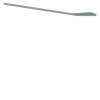

In [102]:
tiles[97]

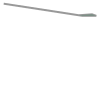

In [103]:
verified_tiles[94]

# Debugging BB2TileExact 

In [12]:
def overlap(a,b):
    if a.area>b.area:
        larger_area = a.area
    else:
        larger_area = b.area
    return a.intersection(b).area/larger_area

In [13]:
def uniquify_tiles(tiles):
    duplicate_count = 0
    verified_tiles = []
    for tidx in tqdm(range(len(tiles))): 
        t=tiles[tidx]
        duplicated=False
        for vtidx in range(len(verified_tiles)):
            vt = tiles[vtidx]
            try:
                overlap_score=overlap(vt,t)
                if overlap_score>0.2:
                    print "Duplicate tiles: ",tidx,vtidx, overlap_score
                    duplicate_count+=1
                    duplicated=True
                    break
            except(shapely.geos.TopologicalError):
                print "Error",tidx,vtidx
        if not duplicated:
            verified_tiles.append(t)
    print "Duplication rate: ", duplicate_count/float(len(tiles))
    return verified_tiles

In [166]:
def compute_unique_tileset(tiles):
    duplicate_count = 0
    verified_tiles = []
    for tidx in tqdm(range(len(tiles))): 
        t=tiles[tidx]
        duplicated=False
        for vtidx in range(len(verified_tiles)):
            vt = tiles[vtidx]
            try:
                overlap_score=overlap(vt,t)
                if overlap_score>0.2:
                    print "Duplicate tiles: ",tidx,vtidx, overlap_score
                    duplicate_count+=1
                    duplicated=True
                    if vt.area<t.area:
                        verified_tiles.remove(vt)
                        verified_tiles.append(t)
                    break
            except(shapely.geos.TopologicalError):
                print "Error",tidx,vtidx
        if not duplicated:
            verified_tiles.append(t)
#     print "Duplication rate: ", duplicate_count/float(len(tiles))
#     return verified_tilesif 
#     if duplicate_count>0:
#         return True
#     else:
#         return False 
    return verified_tiles

In [15]:
DATA_DIR="outputsample"

In [170]:
import copy
objid=10
sampleNworkers=10
bb_objects = bb_info[bb_info["object_id"]==objid]
bb_objects =  bb_objects[bb_objects.worker_id!=3]
# Sampling Data from Ji table 
if sampleNworkers>0 and sampleNworkers<len(bb_objects):
    bb_objects = bb_objects.sample(n=sampleNworkers,random_state=111)
# Create a list of polygons based on worker BBs 
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
BB = []
for xyloc in xylocs:
    BB.append(Polygon(xyloc).buffer(0))
###################################
tqdm_on=True
save_tiles=False
tiles=[]
if tqdm_on: 
    BB_lst = tqdm(range(len(BB)))
else:
    BB_lst=range(len(BB))
all_tiles=[]
for i in BB_lst:
    bi = BB[i]
    # base case, when i=0, only 2 polygon intersecting
    if i==0:
        tiles.append(bi)
    else: 
        xj_lst = []
        tiles_tmp =copy.deepcopy(tiles)
        for tj in tiles:
            
            try:
                xj=tj.intersection(bi)
                if xj.area>1e-10:# and overlap(xj,tj)<0.2: #eliminating spurious LineString-looking Polygons 
#                     print tj in tiles
#                     print tj in tiles
                    #diff_region = (tj.symmetric_difference(xj)).difference(xj)#.buffer(0)
                    diff_region = tj.difference(xj)
                    if diff_region.area>1e-10:  # If highly overlapping then the differnce would be ~0, don't put in overlapping tiles
                        tiles_tmp.remove(tj)
                        #print "Adding intersection starting: ",len(tiles)
                        add_object_to_tiles(tiles_tmp,xj)
                        #print "Adding diff_region starting: ",len(tiles)
                        add_object_to_tiles(tiles_tmp,diff_region)
                        #if xj.intersects(diff_region):
                        if xj.intersection(diff_region).area>1e-8:
                            print "break #1"
                            break
                        #if xj.union(diff_region).area!=tj.area:
                        if not np.isclose(xj.union(diff_region).area,tj.area,rtol=1e-8):
                            print "break#2"
                            print xj.union(diff_region).area
                            print tj.area
                            print xj.union(diff_region).area==tj.area
                            break
                        # check xj and diff region non overlap
                        
                    xj_lst.append(xj)
            except(shapely.errors.TopologicalError):
                xj_lst=xj_lst[:-1]
                pass
        print "tiles:",len(tiles)
        print "tiles_tmp:", len(tiles_tmp)
#         tiles=tiles_tmp[:]
        try:
            test = cascaded_union(tiles)
        except(ValueError):
            test=slow_cascaded_union(tiles)
                
        tiles =copy.deepcopy(tiles_tmp)
        try:
#             leftovers = bi.difference(cascaded_union(xj_lst))
            leftovers = bi.difference(bi.intersection(test))
            leftovers = leftovers.difference(leftovers.intersection(cascaded_union(xj_lst)))
            if len(tiles)>69 and leftovers.intersection(tiles[69]).area>1e-8:
                print "break#3.5"
                print leftovers.intersection(cascaded_union(xj_lst)).area
                break
            if leftovers.intersection(cascaded_union(xj_lst)).area>1e-6:
                print leftovers.intersection(cascaded_union(xj_lst)).area
                print "break #3"
                break
            if not np.isclose(leftovers.union(cascaded_union(xj_lst)).area,bi.area,rtol=1e-8):
                print "pass through break #4"
                print leftovers.union(cascaded_union(xj_lst)).area - bi.area

#             break
                
        except(shapely.errors.TopologicalError):
            try: 
                leftovers = bi.difference(cascaded_union(xj_lst).buffer(1e-10))
            except(shapely.errors.TopologicalError):
                leftovers=[]	
        except(ValueError):
            #ERROR:shapely.geos:TopologyException: no outgoing dirEdge 
            leftovers=[]
        #print "Adding leftovers starting: ",len(tiles)
        add_object_to_tiles(tiles,leftovers)
        #print "Finished leftovers starting: ",len(tiles)
    all_tiles.append(tiles)
    uniquify_tiles = compute_unique_tileset(tiles)
    boolean_uniquify_tiles = len(uniquify_tiles)==len(tiles)
    if not boolean_uniquify_tiles:
        print "BAD: BB",i
        #tiles = uniquify_tiles
        break 
if save_tiles: pkl.dump(tiles,open('tiles{0}.pkl'.format(objid),'w'))

tiles: 1
tiles_tmp: 4
tiles: 7
tiles_tmp: 29
pass through break #4

 30%|███       | 3/10 [00:00<00:00,  7.02it/s]


-5.41071428572
tiles:

 37
tiles_tmp: 66
tiles:

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (448 340, 468.156 346.45) and LINESTRING (479.75 340.929, 468.156 346.45) at 468.15550239234437 346.4497607655502
                                                

 69
tiles_tmp: 103
tiles:

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (535.333 247, 530 239) and LINESTRING (533.692 244.538, 534.235 246.059) at 533.69230769199999 244.53846153800006
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (473 343, 474.056 342.556) and LINESTRING (474.056 342.556, 472.659 342.955) at 474.05555555555549 342.55555555555554
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (473 343, 474.056 342.556) and LINESTRING (474.056 342.556, 472.659 342.955) at 474.05555555555549 342.55555555555554
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (538.045 256.727, 535.052 248.345) and LINESTRING (536.739 253.071, 535.052 248.345) at 535.24490154631417 248.8857243296795
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (538.045 256.727, 535.052 248.345) and LINESTRING (536.739 253.071, 535.052 248.345) at 535.244

 110
tiles_tmp: 173
Throwing away:

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (563 298, 562.714 297.714) and LINESTRING (563.133 298.867, 562.714 297.714) at 562.71428571428578 297.71428571428584
 97%|█████████▋| 174/180 [00:03<00:00, 45.61it/s]

 15508.2817328
Duplicate tiles:  174 8 0.350334018497
Duplicate tiles: 

 60%|██████    | 6/10 [00:08<00:05,  0.67it/s]

 179 42 0.349503498765
BAD: BB 5
tiles:

ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-intersection at or near point 535.99999999998954 247.9999999999944 at 535.99999999998954 247.9999999999944
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (564.173 308.965, 563.939 310.365) and LINESTRING (563.6 312.4, 564.44 307.36) at 564.11587767533467 309.30473394799208
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (473 343, 474.056 342.556) and LINESTRING (474.056 342.556, 472.659 342.955) at 474.05555555555549 342.55555555555554
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (473 343, 474.056 342.556) and LINESTRING (474.056 342.556, 472.659 342.955) at 474.05555555555549 342.55555555555554
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.765 255.941, 535.052 248.345) and LINESTRING (535.052 248.345, 536.045 251.126) at 535.37417215894959 249.24768204505884

 178
tiles_tmp: 234
Duplicate tiles: 

 133 51 0.649665981336
BAD: BB 6
tiles:

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (502 230.929, 512.625 234.344) and LINESTRING (502 231, 507.2 232.6) at 507.20000000000039 232.60000000000011
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.765 255.941, 535.052 248.345) and LINESTRING (535.052 248.345, 536.045 251.126) at 535.37417215894959 249.24768204505884
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (537.765 255.941, 535.052 248.345) and LINESTRING (535.052 248.345, 536.045 251.126) at 535.37417215894959 249.24768204505884
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (535.052 248.345, 533.636 246.727) and LINESTRING (535.052 248.345, 535.052 248.345) at 535.05172413793105 248.34482758620692
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (539.974 262.128, 535.819 250.494) and LINESTRING (539 258, 538.045 256.727) at 53

 233
tiles_tmp: 315
Throwing away:

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (540 257.444, 535.348 249.174) and LINESTRING (535.348 249.174, 537.765 255.941) at 535.3478260869565 249.17391304347825
 73%|███████▎  | 240/330 [00:06<00:02, 34.68it/s]

 14576.494495
Duplicate tiles: 

 91%|█████████ | 300/330 [00:11<00:01, 26.73it/s]

 251 167 0.999999996353
Duplicate tiles:  315 198 0.957957779415
Duplicate tiles:  316 225 0.999999999861
Duplicate tiles:  322 133 0.434138001101
Duplicate tiles:  323 270 0.799826961343
Duplicate tiles:  324 284 0.992957998812
Duplicate tiles:  326 25 0.802491357102
Duplicate tiles:  327 148 0.999999999288
Duplicate tiles: 

 328 20 0.999999999752
BAD: BB 7
tiles:

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (480.089 226.673, 483.605 226.907) and LINESTRING (483.605 226.907, 483.404 226.876) at 483.6046511627905 226.90697674418604
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (530.182 334.273, 519.692 334.692) and LINESTRING (530.182 334.273, 525.676 334.453) at 529.44878517680604 334.3020485929278
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (530.182 334.273, 519.692 334.692) and LINESTRING (530.182 334.273, 525.676 334.453) at 529.44878517680604 334.3020485929278
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (530.182 334.273, 520.368 334.665) and LINESTRING (525.676 334.453, 519.692 334.692) at 523.38761988350427 334.54449520465982
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (530.182 334.273, 520.368 334.665) and LINESTRING (525.676 334.453, 5

 321
tiles_tmp: 423
Throwing away:

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (397.388 306.336, 402.312 313.532) and LINESTRING (397.388 306.336, 402.312 313.532) at 398.61887035378408 308.13527205553061
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (421.647 225.353, 424 225) and LINESTRING (429.729 223.814, 421.647 225.353) at 421.64705882352968 225.35294117647055


 349.767486522


ValueError: No Shapely geometry can be created from null value

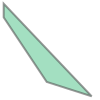

In [161]:
tiles[179]

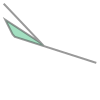

In [162]:
tiles[42]

In [164]:
tiles[179].intersection(tiles[42]).area

11.701613802565394

In [159]:
def slow_cascaded_union(tiles):
    all_tiles  = copy.deepcopy(tiles)
    Utile=tiles[0]
    all_tiles.remove(tiles[0])
    i=1
    loss_tiles = []
    while(len(all_tiles)>0):
        tile = tiles[i]
        try:
            Utile = Utile.union(tile)
        except(shapely.geos.TopologicalError):
            try:
                Utile =Utile.buffer(0).union(tile.buffer(0))
            except(shapely.geos.TopologicalError):
                #print "Throwing away:", tile.area 
                loss_tiles.append(tile)
        all_tiles.remove(tile)
        i+=1
    try:
        Utile=Utile.union(cascaded_union(loss_tiles))
    except(shapely.geos.TopologicalError):
        print "Throwing away:", sum([t.area for t in loss_tiles])
    return Utile

In [132]:
Utile=tiles[0]
for tile,i in zip(tiles[1:],range(len(tiles))):
    try:
        Utile = Utile.union(tile)
    except(shapely.geos.TopologicalError):
        print i
        Utile =Utile.buffer(0).union(tile.buffer(0))
        print tile.area 
        pass 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (564.173 308.965, 563.939 310.365) and LINESTRING (563.6 312.4, 564.44 307.36) at 564.11587767533467 309.30473394799208
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (473 343, 474.056 342.556) and LINESTRING (474.056 342.556, 472.659 342.955) at 474.05555555555549 342.55555555555554


53
0.37935483871
63

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (473 343, 474.056 342.556) and LINESTRING (474.056 342.556, 472.659 342.955) at 474.05555555555549 342.55555555555554


TopologicalError: This operation could not be performed. Reason: unknown

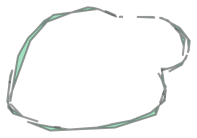

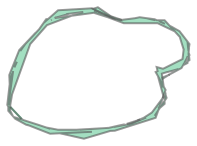

In [125]:
Utile

In [119]:
tiles[89].area

0.4846518987341657

In [85]:
shapely.ops.unary_union([cascaded_union(tiles[:-1]),tiles[-1]])

ERROR:shapely.geos:TopologyException: Input geom 1 is invalid: Self-intersection at or near point 535.99999999998954 247.9999999999944 at 535.99999999998954 247.9999999999944


ValueError: No Shapely geometry can be created from null value

In [75]:
shapely.ops.unary_union([cascaded_union(tiles[:-1]),tiles[-1]]).area-cascaded_union(tiles[:-1]).area

166.27791543755666

In [74]:
tiles[-1].area

166.2779154423609

In [37]:
print bi.intersection(test).area-cascaded_union(xj_lst).intersection(test).area

459.458073583


In [38]:
bi.intersection(test).area

16457.301100836838

In [39]:
cascaded_union(xj_lst).intersection(test).area

15997.843027253852

In [18]:
leftovers.intersection(tiles[69]).area

158.51840711432743

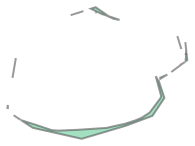

In [20]:
leftovers

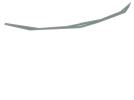

In [25]:
tiles[69]

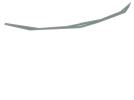

In [22]:
leftovers.intersection(tiles[69])

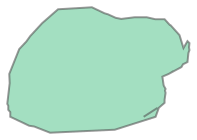

In [28]:
cascaded_union(xj_lst).union(cascaded_union(tiles))

In [24]:
tiles[69].intersection(cascaded_union(xj_lst))

In [23]:
tiles[69].area

158.51840711432752

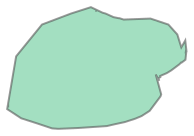

In [438]:
cascaded_union(xj_lst)

In [436]:
leftovers.intersection(cascaded_union(xj_lst)).area

0.0

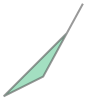

In [390]:
tiles[36]

The problem is in the leftovers but not too sure what we could do in these case, other than throwing it out if the area is not too large 

In [402]:
mtiles = shapely.geometry.MultiPolygon(tiles)

In [406]:
# leftover.intersects(mtiles)

In [408]:
mtiles= cascaded_union(mtiles)

In [423]:
leftover.intersects(mtiles)

True

In [426]:
for leftover,i in zip(leftovers,range(len(leftovers))): 
    print i
#     print leftover.intersection(mtiles).area
    print leftover.intersection(tiles[36]).area
    print leftover.intersection(tiles[69]).area

0
0.0
0.0
1
0.0
0.0
2
0.0
0.0
3
0.0
0.0
4
0.0
0.0
5
0.0
0.0
6
0.0
0.0
7
0.553846153843
0.0
8
0.0
0.0
9
0.0
0.0
10
0.0
158.518407114
11
0.0
0.0
12
0.0
0.0
13
0.0
0.0


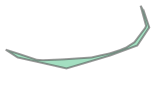

In [419]:
leftovers[10]

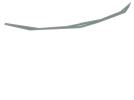

In [418]:
tiles[69]

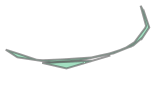

In [422]:
leftovers[10].difference(tiles[69])

If overlap, then add in only the region that is the difference between the tile and the problematic leftover chunnk 

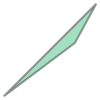

In [415]:
leftovers[7].intersection(tiles[36])

In [395]:
leftovers.intersection(tiles[36]).area

0.553846153842885

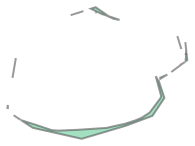

In [391]:
leftovers

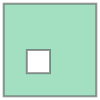

In [381]:
#embedded objects are definitely doable
Polygon([[0,0],[4,0],[4,4],[0,4]]).difference(Polygon([[1,1],[2,1],[2,2],[1,2]]))

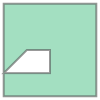

In [382]:
Polygon([[0,0],[4,0],[4,4],[0,4]]).difference(Polygon([[0,1],[2,1],[2,2],[1,2]]))

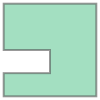

In [40]:
Polygon([[0,0],[4,0],[4,4],[0,4]]).difference(Polygon([[0,1],[2,1],[2,2],[-1,2]]))

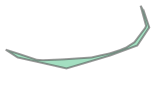

In [374]:
tiles[-1]

In [376]:
xj

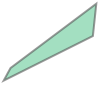

In [375]:
diff_region

In [309]:
mpld3.disable_notebook()

In [371]:
def visualizeTilesSeparate(tiles,colorful=True):
    plt.figure()
    colors=cm.rainbow(np.linspace(0,1,len(tiles)))
    for t,i in zip(tiles,range(len(tiles))): 
#         plt.figure()
        if colorful: 
            c = colors[i]
        else: 
            c="lime"
        if type(t)==shapely.geometry.polygon.Polygon:
            plot_coords(t,color=c,reverse_xy=True)
        elif type(t)==shapely.geometry.MultiPolygon or type(t)==shapely.geometry.collection:
            for region in t:
                
                if type(t)!=shapely.geometry.LineString:
                    plot_coords(region,color=c,reverse_xy=True)

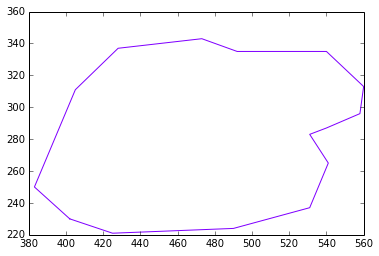

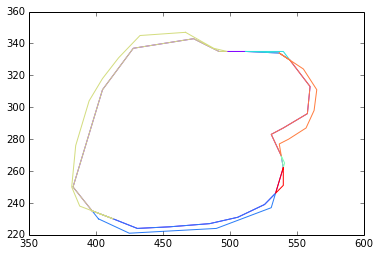

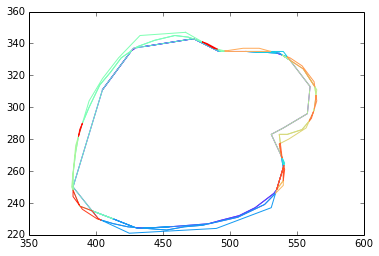

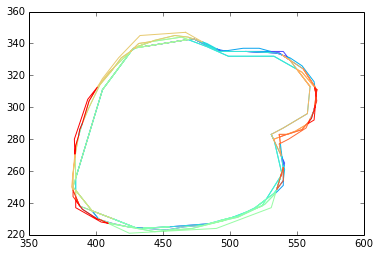

In [372]:
for i in range(0,4):
    visualizeTilesSeparate(all_tiles[i],colorful=True)

In [334]:
verified_tiles = uniquify_tiles(tiles)

 95%|█████████▍| 105/111 [00:01<00:00, 68.24it/s]

Duplicate tiles:  108 36 0.615384615381
Duplicate tiles: 

 110 69 0.251446936416
Duplication rate:  0.018018018018


In [296]:
verified_tiles = uniquify_tiles(tiles)

 87%|████████▋ | 156/180 [00:02<00:00, 52.64it/s]

Duplicate tiles:  85 1 0.574316220475
Duplicate tiles:  86 12 0.34169033311
Duplicate tiles:  87 2 0.208353162071
Duplicate tiles:  169 130 0.300502057227
Duplicate tiles:  171 132 1.0
Duplicate tiles:  172 131 0.408076289986
Duplicate tiles:  173 133 1.0
Duplicate tiles:  174 134 1.0
Duplicate tiles:  176 136 0.31476718591
Duplicate tiles:  177 142 1.0
Duplicate tiles: 

 179 143 0.273614764612
Duplication rate:  0.0611111111111


In [293]:
verified_tiles = uniquify_tiles(tiles)

 42%|████▏     | 54/129 [00:00<00:00, 147.99it/s]

Duplicate tiles:  12 1 0.80931112436
Duplicate tiles: 

 63%|██████▎   | 81/129 [00:00<00:00, 82.06it/s] 

 74 19 0.245048936855
Duplicate tiles:  86 12 0.401109013658
Duplicate tiles:  101 82 0.393232086534
Duplicate tiles: 

 84%|████████▎ | 108/129 [00:01<00:00, 61.53it/s]

 104 85 0.240587028067
Duplicate tiles:  105 88 0.474510720937
Duplicate tiles: 

 115 58 0.429429356167
Duplication rate:  0.0542635658915


In [291]:
verified_tiles = uniquify_tiles(tiles)

 87%|████████▋ | 156/180 [00:02<00:00, 54.46it/s]

Duplicate tiles:  85 1 0.574316220475
Duplicate tiles:  86 12 0.34169033311
Duplicate tiles:  87 2 0.208353162071
Duplicate tiles:  169 130 0.300502057227
Duplicate tiles:  171 132 1.0
Duplicate tiles:  172 131 0.408076289986
Duplicate tiles:  173 133 1.0
Duplicate tiles:  174 134 1.0
Duplicate tiles:  176 136 0.31476718591
Duplicate tiles:  177 142 1.0
Duplicate tiles: 

 179 143 0.273614764612
Duplication rate:  0.0611111111111


In [287]:
verified_tiles = uniquify_tiles(tiles)

 39%|███▉      | 50/129 [00:00<00:00, 152.85it/s]

Duplicate tiles:  12 1 0.80931112436
Duplicate tiles: 

 58%|█████▊    | 75/129 [00:00<00:00, 88.89it/s] 

 74 19 0.245048936855
Duplicate tiles: 

 78%|███████▊  | 100/129 [00:01<00:00, 69.55it/s]

 86 12 0.401109013658
Duplicate tiles:  101 82 0.393232086534
Duplicate tiles:  104 85 0.240587028067
Duplicate tiles:  105 88 0.474510720937
Duplicate tiles: 

 115 58 0.429429356167
Duplication rate:  0.0542635658915


In [248]:
verified_tiles = uniquify_tiles(tiles)

  6%|▋         | 27/416 [00:00<00:01, 252.59it/s]

Duplicate tiles:  21 5 0.31008061062
Duplicate tiles:  35 10 0.206155955088
Duplicate tiles:  40 14 0.20091848432
Duplicate tiles: 

 13%|█▎        | 54/416 [00:00<00:02, 151.66it/s]

 50 11 0.345841372341
Duplicate tiles: 

 19%|█▉        | 81/416 [00:00<00:03, 107.56it/s]

 64 37 1.0
Duplicate tiles:  66 34 0.392749919017
Duplicate tiles: 

 26%|██▌       | 108/416 [00:01<00:03, 81.06it/s]

 84 70 0.331138266295
Duplicate tiles:  117 77 0.768948902195
Duplicate tiles:  130 58 0.374493927125
Duplicate tiles:  132 19 0.273233047586
Duplicate tiles: 

 32%|███▏      | 135/416 [00:02<00:04, 65.29it/s]

 133 115 0.319467381725
Duplicate tiles:  144 10 0.227713653302
Duplicate tiles:  146 74 0.266625889417
Duplicate tiles:  147 94 0.436380851378
Duplicate tiles:  154 43 0.543185620517
Duplicate tiles:  156 71 1.0
Duplicate tiles:  158 8 0.912132089017
Duplicate tiles: 

 39%|███▉      | 162/416 [00:02<00:04, 56.86it/s]

 159 40 0.665434192874
Duplicate tiles:  164 95 0.22634272624
Duplicate tiles:  166 144 0.418076128861
Duplicate tiles:  167 143 0.489185914336
Duplicate tiles:  168 39 0.257752985551
Duplicate tiles:  172 115 0.213396882655
Duplicate tiles:  173 56 0.508184782296
Duplicate tiles:  182 126 0.710416666667
Duplicate tiles: 

 45%|████▌     | 189/416 [00:03<00:04, 49.97it/s]

 187 126 1.0
Duplicate tiles:  190 34 0.209450156284
Duplicate tiles:  193 164 0.251700947657
Duplicate tiles:  201 49 1.0
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (497.795 229.437, 502.729 230.377) and LINESTRING (498.543 229.58, 498.543 229.58) at 498.54347826086956 229.57971014492753


 206 118 0.245048936739
Error

 52%|█████▏    | 216/416 [00:04<00:04, 43.95it/s]

 213 162
Duplicate tiles:  230 73 0.571145978436
Duplicate tiles:  231 73 0.428854021564
Duplicate tiles:  232 189 0.647007642179
Duplicate tiles: 

 58%|█████▊    | 243/416 [00:06<00:04, 39.64it/s]

 236 67 1.0
Duplicate tiles:  244 104 0.20454470824
Duplicate tiles:  247 70 0.37169418795
Duplicate tiles:  251 207 0.271165852143
Duplicate tiles:  260 62 0.230743463829
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (535.052 248.345, 535.052 248.345) and LINESTRING (535.052 248.345, 535.052 248.345) at 535.05172413793105 248.34482758620689


 262 217 0.543995400881
Error

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (508.222 231.889, 506 231) and LINESTRING (503.73 230.568, 508.222 231.889) at 508.22222222222211 231.88888888888883
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (521.455 237.182, 522.83 237.732) and LINESTRING (522.835 237.734, 521.455 237.182) at 522.66020279922679 237.66408111969071


 265 52
Error 265 111
Error

 65%|██████▍   | 270/416 [00:07<00:04, 35.28it/s]

 265 213
Duplicate tiles:  270 16 0.332380764329
Duplicate tiles:  278 229 0.433863670214
Duplicate tiles:  281 202 0.74894904765
Duplicate tiles:  282 192 0.383859351944
Duplicate tiles:  284 33 1.0
Duplicate tiles:  288 107 0.222057297702
Duplicate tiles: 

 71%|███████▏  | 297/416 [00:09<00:03, 32.62it/s]

 293 186 1.0
Duplicate tiles:  299 24 0.350534425003
Duplicate tiles:  305 248 0.917376397176
Duplicate tiles:  311 43 0.34718189697
Duplicate tiles:  312 211 0.999999999999
Duplicate tiles:  318 225 0.76550190005
Duplicate tiles:  320 60 0.856012786686
Duplicate tiles: 

 78%|███████▊  | 324/416 [00:10<00:03, 30.49it/s]

 323 35 0.771757103741
Duplicate tiles:  326 74 0.338148890834
Duplicate tiles:  331 245 1.0
Duplicate tiles:  332 38 0.276252804647
Duplicate tiles:  333 119 0.999999999866
Duplicate tiles:  334 262 0.227674443489
Duplicate tiles:  337 274 0.587021644897
Duplicate tiles:  339 262 0.208748501147
Duplicate tiles:  342 237 0.711396846629
Duplicate tiles:  343 246 1.0
Duplicate tiles:  344 56 0.302040060528
Duplicate tiles: 

 84%|████████▍ | 351/416 [00:12<00:02, 29.02it/s]

 346 144 0.241626326126
Duplicate tiles:  347 29 1.0
Duplicate tiles:  351 38 0.228988598807
Duplicate tiles:  354 10 0.310078271127
Duplicate tiles:  355 138 0.891635939199
Duplicate tiles:  356 210 0.968615738795
Duplicate tiles:  362 193 0.635208639377
Duplicate tiles:  366 237 0.207566724905
Duplicate tiles:  368 102 0.833635615502
Duplicate tiles:  369 87 0.850734296596
Duplicate tiles: 

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (495.875 228.622, 496.874 228.98) and LINESTRING (495.874 228.621, 496.874 228.98) at 495.87481049021488 228.62172684264124


 371 189 0.260108362891
Error 375 213
Duplicate tiles: 

 91%|█████████ | 378/416 [00:13<00:01, 27.13it/s]

 377 27 0.999999999996
Duplicate tiles:  379 152 0.433208684791
Duplicate tiles:  380 219 0.68199489451
Duplicate tiles:  382 175 1.0
Duplicate tiles:  385 242 1.0
Duplicate tiles:  391 246 1.0
Duplicate tiles:  393 109 0.35936922584
Duplicate tiles:  394 246 1.0
Duplicate tiles:  397 74 0.436576310731
Duplicate tiles:  399 144 0.418076128878
Duplicate tiles:  400 195 0.399604936052
Duplicate tiles:  402 34 0.404155126236
Duplicate tiles: 

 97%|█████████▋| 405/416 [00:15<00:00, 25.81it/s]

 404 78 0.816024698447
Duplicate tiles:  406 81 0.566990291262
Duplicate tiles:  408 15 0.339343769545
Duplicate tiles:  409 49 0.834677564788
Duplicate tiles:  410 70 0.628305812228
Duplicate tiles:  412 36 0.30163762712
Duplicate tiles: 

 414 163 0.999999998696
Duplicate tiles:  415 35 0.228242896194
Duplication rate:  0.225961538462


In [239]:
verified_tiles = uniquify_tiles(tiles)

Duplicate tiles:  23 9 0.525784972531
Duplication rate:  0.025


In [227]:
verified_tiles = uniquify_tiles(tiles)

 35%|███▌      | 24/68 [00:00<00:00, 232.61it/s]

Duplicate tiles:  16 7 0.252926682244
Duplicate tiles:  31 14 0.500978372792
Duplicate tiles:  38 10 0.239083008933
Duplicate tiles: 

 71%|███████   | 48/68 [00:00<00:00, 146.18it/s]

 45 6 0.380479511143
Duplicate tiles:  50 16 0.333165042377
Duplicate tiles:  52 0 0.979030606475
Duplicate tiles:  55 18 0.816447215504
Duplicate tiles:  59 9 0.326278035124
Duplicate tiles:  60 13 0.3242768532
Duplicate tiles: 

 63 21 0.553948633765
Duplicate tiles:  64 10 0.56084743857
Duplicate tiles:  67 17 1.0
Duplication rate:  0.176470588235


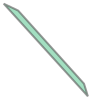

In [202]:
tiles[46]

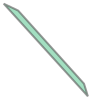

In [203]:
tiles[43]

In [194]:
def visualizeTiles(tiles,colorful=True):
    plt.figure()
    colormap = plt.cm.Paired
    colors = [colormap(i) for i in np.linspace(0, 1,len(tiles))]
    for t,i in zip(tiles,range(len(tiles))): 
        if colorful: 
            c = colors[i]
        else: 
            c="lime"
        if type(t)==shapely.geometry.polygon.Polygon:
            plot_coords(t,color=c,reverse_xy=True)
        elif type(t)==shapely.geometry.MultiPolygon or type(t)==shapely.geometry.collection:
            for region in t:
                if type(t)!=shapely.geometry.LineString:
                    plot_coords(region,color=c,reverse_xy=True)

In [195]:
import mpld3
mpld3.enable_notebook()

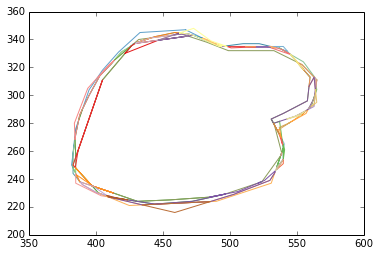

In [196]:
visualizeTiles(verified_tiles)

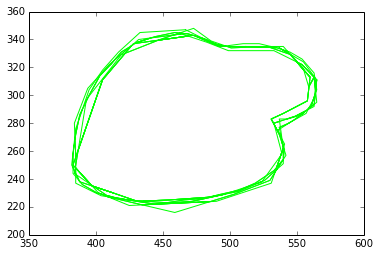

In [182]:
visualizeTiles(tiles)

----------------------------------------------------------------

In [197]:
def BB2TileExact(objid,BB,tqdm_on=False,save_tiles=True):
	'''
	Given a list of worker polygons BB (potentially sampled) and the objectID 
	return a list of non-overlapping tiles (shapely Polygon objects)
	# BB is a list of polygons based on worker BBs 
	'''	
	tiles=[]
	if tqdm_on: 
	    BB_lst = tqdm(range(len(BB)))
	else:
	    BB_lst=range(len(BB))
	for i in BB_lst:
	    bi = BB[i]
	    # base case, when i=0, only 2 polygon intersecting
	    if i==0:
	        tiles.append(bi)
	    else: 
	        xj_lst = []
	        for tj in tiles:
	            try:
	                xj=tj.intersection(bi)
	                if xj.area>1e-10: #eliminating spurious LineString-looking Polygons 
	                    tiles.remove(tj)
	                    add_object_to_tiles(tiles,xj)
	                    diff_region = (tj.symmetric_difference(xj)).difference(xj)#.buffer(0)
	                    add_object_to_tiles(tiles,diff_region)       
	                    xj_lst.append(xj)
	            except(shapely.errors.TopologicalError):
	                xj_lst=xj_lst[:-1]
	                pass
	        try:
	            leftovers = bi.difference(cascaded_union(xj_lst))
	        except(shapely.errors.TopologicalError):
	        	try: 
		            leftovers = bi.difference(cascaded_union(xj_lst).buffer(1e-10))
		        except(shapely.errors.TopologicalError):
		        	leftovers=[]	
	        except(ValueError):
	            #ERROR:shapely.geos:TopologyException: no outgoing dirEdge 
	            leftovers=[]
	            
	        add_object_to_tiles(tiles,leftovers)
	if save_tiles: pkl.dump(tiles,open('tiles{0}.pkl'.format(objid),'w'))
	return tiles


In [157]:
def createObjIndicatorMatrix(objid,load_existing_tiles=False, PLOT=False,sampleNworkers=-1,random_state=111,PRINT=False,SAVE=False,EXCLUDE_BBG=True,overlap_threshold=0.8,tile_only=False,tqdm_on=False):

    # Ji_tbl (bb_info) is the set of all workers that annotated object i 
    bb_objects = bb_info[bb_info["object_id"]==objid]
    if EXCLUDE_BBG: bb_objects =  bb_objects[bb_objects.worker_id!=3]
    # Sampling Data from Ji table 
    if sampleNworkers>0 and sampleNworkers<len(bb_objects):
        bb_objects = bb_objects.sample(n=sampleNworkers,random_state=random_state)
    # Create a list of polygons based on worker BBs 
    xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
    BB = []
    for xyloc in xylocs:
        BB.append(Polygon(xyloc).buffer(0))
    #Compute Tiles 
    if load_existing_tiles:
    	tiles = pkl.load(open("{0}/tiles{1}.pkl".format(DATA_DIR,objid),'r'))
    else:
	    tiles = BB2TileExact(objid,BB,tqdm_on=tqdm_on,save_tiles=SAVE)
    if tile_only:
    	if PLOT: visualizeTiles(tiles)
    	return tiles,0
    # Convert set of tiles to indicator matrix for all workers and tiles
    # by checking if the worker's BB contains the tile pieces
    # The indicator matrix is a (N + 1) X M matrix, 
    # with first N rows indicator vectors for each annotator and
    # the last row being region sizes
    worker_lst  = list(bb_objects.worker_id)
    M = len(tiles)
    N = len(worker_lst)
    if PRINT: 
        print "Number of non-overlapping tile regions (M) : ",M
        print "Number of workers (N) : ",N
    indicator_matrix = np.zeros((N+1,M))

    for  wi in range(N):
        worker_id = worker_lst[wi]
        worker_bb_info = bb_objects[bb_objects["worker_id"]==worker_id]
        worker_BB_polygon = Polygon(zip(*process_raw_locs([worker_bb_info["x_locs"].values[0],worker_bb_info["y_locs"].values[0]]))).buffer(0)

        # Check if worker's polygon contains this tile
        for tile_i in range(M):
            tile = tiles[tile_i]
            if worker_BB_polygon.contains(tile.centroid):
                indicator_matrix[wi][tile_i]=1
            else:
            	try:
            		tileBB_overlap = tile.intersection(worker_BB_polygon).area/float(tile.area)
            		if tileBB_overlap>=overlap_threshold:
            			indicator_matrix[wi][tile_i]=1
            	except(shapely.errors.TopologicalError):
            		pass

    # The last row of the indicator matrix is the tile area
    for tile_i in range(M):
        tile=tiles[tile_i]
        indicator_matrix[-1][tile_i]=tile.area
    # Debug plotting all tiles that have not been voted by workers 
    all_unvoted_tiles=np.where(np.sum(indicator_matrix[:-1],axis=0)==0)[0]
    if PRINT:
        print "all unvoted tiles:",all_unvoted_tiles
        print "all unvoted workers:",np.where(np.sum(indicator_matrix,axis=1)==0)[0]
    if PLOT or PRINT:
        print "Object ",objid
        sanity_check(indicator_matrix,PLOT)
    if SAVE:
    	pkl.dump(worker_lst,open('../{0}/worker{1}.pkl'.format(DATA_DIR,objid),'w'))
    	pkl.dump(indicator_matrix,open('../{0}/indMat{1}.pkl'.format(DATA_DIR,objid),'w'))
    return worker_lst,tiles,indicator_matrix

In [159]:
def PR_compare(objid,sampleNworkers=40):    
    os.chdir("..")
    worker_lst,tiles,indicatorMat= createObjIndicatorMatrix(objid,PRINT=True,sampleNworkers=sampleNworkers,tqdm_on=False,SAVE=True,tile_only=False)
    os.chdir(DATA_DIR)
    
    worker_precision_lst,worker_recall_lst = compute_worker_lst_PR_obj(objid,worker_lst)
    best_worker =  np.argmax(worker_recall_lst)
    print "Best worker's PR against BBG: ", max(worker_precision_lst),max(worker_recall_lst)

    approved_tiles = np.where(indicatorMat[best_worker]==1)[0]
    for tidx in approved_tiles:
        plot_coords(tiles[tidx],color="lime")

    bb_objects = bb_info[bb_info["object_id"]==objid]
    bb_objects =  bb_objects[bb_objects.worker_id!=3]
    
    best_worker_id = worker_lst[best_worker]
    worker_bb_info = bb_objects[bb_objects["worker_id"]==best_worker_id]
    worker_BB_polygon = Polygon(zip(*process_raw_locs([worker_bb_info["x_locs"].values[0],worker_bb_info["y_locs"].values[0]])))#.buffer(0)

    plot_coords(worker_BB_polygon,linestyle='--',color='#0000ff')
    
    joined_bb = join_tiles(approved_tiles,tiles)

    if type(joined_bb)==list:
        intersect_area =0
        joined_bb_area =0
        for jbb in joined_bb:
            ia = intersection_area(worker_BB_polygon,jbb)
            intersect_area += ia
            joined_bb_area += jbb.area
    else:
        intersect_area=intersection_area(worker_BB_polygon,joined_bb)
        joined_bb_area =joined_bb.area
    precision = intersect_area/joined_bb_area
    recall = intersect_area/worker_BB_polygon.area
    print precision,recall
    return precision,recall

In [160]:
objid=15
p,r=PR_compare(objid,sampleNworkers=5)

Number of non-overlapping tile regions (M) :  28
Number of workers (N) :  5
all unvoted tiles: []
all unvoted workers: []
Object  15
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: True


IOError: [Errno 2] No such file or directory: '../outputsample/worker15.pkl'

In [161]:
objid=15
p,r=PR_compare(objid,sampleNworkers=5)

Number of non-overlapping tile regions (M) :  28
Number of workers (N) :  5
all unvoted tiles: []
all unvoted workers: []
Object  15
Check that there are no all-zero rows in indicator matrix: True
Check that there are no all-zero columns in indicator matrix: True


IOError: [Errno 2] No such file or directory: '../outputsample/worker15.pkl'